## The challenge

Hospitals prefer to use simpler linear regression (LR) models over neural networks (NN) or even random forests (RF) due to the ease of model explainability - why did the model make a given prediction? However, with the use of SHAP scores, the black box of NNs can be poked and prodded into giving up their secrets. As part of a group project, I made NNs that outperformed “state of the art” LR models used by hospitals as well as Ada-boosted RFs; leaving the task of getting the SHAP values to one of my team members. Below you will find the final model structures used to predict length of stay (LOS - how long a patient was in the hospital) and total cost of a hospital visit, as well as training times and error.

In [32]:
cuda.select_device(0)
cuda.close()

In [91]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn import utils
from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import math
from scipy.stats.mstats import winsorize
from scipy import sparse
from numba import cuda

In [92]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.8.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [93]:
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
for x in local_device_protos:
    print(x.name)

/device:CPU:0
/device:GPU:0


2022-04-26 17:30:51.094279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 17:30:51.096419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 17:30:51.098405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 17:30:51.100628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 17:30:51.102619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [94]:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)


config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2022-04-26 17:30:51.554191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 17:30:51.554927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 17:30:51.555442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 17:30:51.555994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 17:30:51.556455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

## The data

There are two different sets of feature space that can be merged. The first is diagnosis data - what symptoms and/or ailments the patient has been diagnosed with prior to their visit or upon arrival. The second set is an assortment of demographic data that includes things such as (age, sex, and insurance type).

In [95]:
"""
importing one-hot feature data
"""
oh1 = sparse.load_npz("one_hot_1.npz").toarray()
print(oh1.shape)
#print(oh1[0])
oh2 = sparse.load_npz("one_hot_2.npz").toarray()

data = np.concatenate((oh1, oh2))
print(data.shape)

(750000, 492)
(1559496, 492)


In [96]:
"""
Importing target data IDs to link to target values
"""
ids_1 = np.loadtxt(open("record_ids_1.csv"), delimiter=',').astype(int)
print(ids_1.shape)
ids_2 = np.loadtxt(open("record_ids_2.csv"), delimiter=',').astype(int)
print(ids_2.shape)

ids = np.append(ids_1, ids_2)
print(ids.shape)
ids[0]

(750000,)
(809496,)
(1559496,)


718439308

In [97]:
"""
importing target data and extra features (such as insurance status and age group)
"""
raw_tdf = pd.read_csv("data/encounters_CCS.csv")
print(raw_tdf.columns)
tdf = raw_tdf[["BaseMSDRGCode", "AgeGroupCode", "RecordId", "TotalDirectCost", "DeathFlag"]]
tdf.head(3)

Index(['CasesBin', 'RecordId', 'AdmissionSourceCode', 'AdmissionStatusCode',
       'AgeGroupCode', 'SexCode', 'BaseMSDRGCode', 'msdrgcode', 'PayerCode',
       'LOS', 'DeathFlag', 'TotalDirectCost'],
      dtype='object')


,BaseMSDRGCode,AgeGroupCode,RecordId,TotalDirectCost,DeathFlag
0,101,9,1006954969,13022,0
1,101,8,1006955165,5760,0
2,294,8,1006955301,13027,0


In [98]:
raw_tdf.head(2)

,CasesBin,RecordId,AdmissionSourceCode,AdmissionStatusCode,AgeGroupCode,SexCode,BaseMSDRGCode,msdrgcode,PayerCode,LOS,DeathFlag,TotalDirectCost
0,3,1006954969,1,1,9,1,101,291,2,7,0,13022
1,3,1006955165,19,1,8,1,101,291,2,4,0,5760


In [99]:
print(raw_tdf.columns)

Index(['CasesBin', 'RecordId', 'AdmissionSourceCode', 'AdmissionStatusCode',
       'AgeGroupCode', 'SexCode', 'BaseMSDRGCode', 'msdrgcode', 'PayerCode',
       'LOS', 'DeathFlag', 'TotalDirectCost'],
      dtype='object')


In [100]:
raw_tdf.AdmissionSourceCode.unique()

array([ 1, 19,  6,  5,  8,  2,  9, 21,  4, 11, 18, 25, 23, 24])

In [101]:
raw_tdf.CasesBin.unique()

array([3, 4, 2, 5, 1, 6])

In [102]:
mnd = keras.constraints.max_norm(1)

In [121]:
"""
Sub group codes:
65==COPD
101==HF/Shack
152==Maj. joint replacement
294==Septicemia

targets==["TotalDirectCost", "DeathFlag", "LOS"]
"""
def prep_data(group, target, data, ids, raw_tdf):
    #data==SVD data
    #raw_tdf==target data and extra categorical data
    #ids==I think you can guess this one
    #group==code for group
    #target==name of column of target as string
    
    needed_cols = ['AdmissionSourceCode', 'AdmissionStatusCode', 'AgeGroupCode', 
                   'SexCode', 'msdrgcode', 'PayerCode', "RecordId", "BaseMSDRGCode",
                   'LOS', 'DeathFlag', 'TotalDirectCost']
    categorical_columns = ['AdmissionSourceCode', 'AdmissionStatusCode', 'AgeGroupCode', 
                           'SexCode', 'msdrgcode', 'PayerCode']
    extra_df = raw_tdf[needed_cols].copy()
    ohe_df = pd.get_dummies(extra_df, columns=categorical_columns)
    ohe_df["AgeGroupCode"] = raw_tdf["AgeGroupCode"]#adding back age column for use as dense data
    
    
    data = pd.DataFrame(data=data) #converting data into DF format
    diagnosis_shape = data.shape
    data['RecordId'] = ids.tolist() #adding IDs to diagnosis data for merging
    data = data.merge(ohe_df, how="inner", on='RecordId')
    data.drop("RecordId", inplace=True, axis=1) #ID data no longer needed and is in the way
    #well now add age as a dense feature at the very end so it can be easily split off of the one hot data
    data["Age"] = data["AgeGroupCode"]/max(data["AgeGroupCode"]) # scale down values to between 0 and 1
    data.drop(columns=["AgeGroupCode"], inplace=True) #dropping old column
    
    
    #filtering for group
    if group=='tous': #french for 'all' this is used to grab all groups when training a generic model
        features = data.copy()
    else:
        features = data.loc[data["BaseMSDRGCode"]==group].reset_index(drop=True)
    features.drop(columns=["BaseMSDRGCode"], inplace=True) #dropping this column as it is only for filtering
    
    #shuffling dataframe - facilitates taking a random sample for validation set downstream by simply taking first x rows
    features = features.sample(frac=1, random_state=42).reset_index(drop=True)
    
    #pulling out target data and removing it from data; data will be just feature data
    target_values = features[[target]]
    features.drop(['LOS', 'DeathFlag', 'TotalDirectCost'], inplace=True, axis=1) #dropping target columns
    
    
    #Splitting data into, train, validation, and test
    X = np.asarray(features)#sdf.iloc[:, 0:215])
    y = np.asarray(target_values).astype('float32').reshape((-1,1))
    X_train, X_test, y_train_temp, y_test = train_test_split(X, y, 
                                                        test_size=0.1, 
                                                        random_state=42)
    #since data is noisy, we'll 'bring in' the most extreme outliers (1%) but only on training/validation
    #We'll leave test alone to be able to get an accurate estimate of model performance
    #this worked better than using Huber loss
    y_train = winsorize(y_train_temp, limits=[0.01, 0.01])
    #creating validation sets - is random because the data was shuffled earlier
    val_size = round(len(y)*0.1)
    X_valid = X_train[:val_size]
    X_train = X_train[val_size:]
    y_valid = y_train[:val_size]
    y_train = y_train[val_size:]
    #reshaping to make tensorflow happy
    y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
    y_valid = np.asarray(y_valid).astype('float32').reshape((-1,1))
    y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
    
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, diagnosis_shape

In [27]:
from matplotlib.ticker import PercentFormatter

## Data distribution and outliers

Next we will plot histograms for the cost target for each of the 4 groups. 
This will help us get a better understanding of the data, as well as the challenges.
The meanline in plotted and should be kept in mind when looking at mean absolute
error of the models. 

Of important note is the size of the X-axis; this is not a formating error, the
outliers are just VERY out there, causing some dilemmas. Because of the medical
setting it was decided that simply throwing out the outliers was not an acceptable
options, at least not in terms of meassuring the error. So, to deal with them, both
Huber loss (a loss function that helps with noisy data) and winsorizing (clipping the
extreme values - in this case the bottom and top 1%) the training data were used.

the effects of winsorizing can be seen on the right tails of the histograms; the little
and sudden peak represents all the instances that would have been further to the right
as they all get piled into the fina clipped bin.

In the end, winsorizing ended up working best on this dataset. 

In [122]:
X_train, X_valid, X_test, y_train, y_valid, y_test, ds = prep_data(group='tous', target='TotalDirectCost', 
                                                      data=data, ids=ids, raw_tdf=raw_tdf)

X_age_train = X_train[:, -1:]
X_age_valid = X_valid[:, -1:]
X_age_test = X_test[:, -1:]

X_train = X_train[:, :-1]
X_valid = X_valid[:, :-1]
X_test = X_test[:, :-1]

print(X_train.shape)
print(X_valid.shape)

(1247596, 544)
(155950, 544)


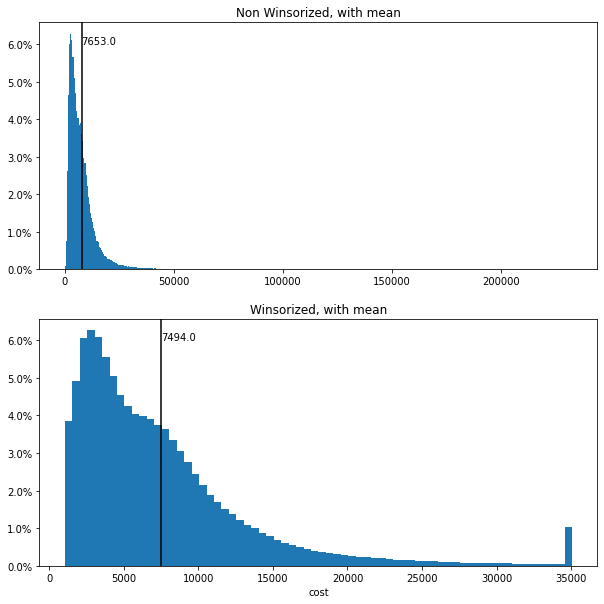

In [132]:
"""
Plotting a histogram of target values for all tje data
in order to get a quick glimpse at the distribution of 
the cost target
"""
test_weights =  [1/len(y_test)]*len(y_test)
train_weights = [1/len(y_train)]*len(y_train)
w = 500 #bin width

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))

ax1.hist(y_test, weights=test_weights,
         bins=np.arange(min(y_test), max(y_test)+w, w))
ax1.axvline(y_test.mean(), color='black')
ax1.text(y_test.mean(), 0.06, str(np.round(y_test.mean(), 0)))
ax1.set_title('Non Winsorized, with mean')
ax1.yaxis.set_major_formatter(PercentFormatter(1))

ax2.hist(y_train, weights=train_weights,
         bins=np.arange(min(y_train), max(y_train)+w, w))
ax2.axvline(y_train.mean(), color='black')
ax2.text(y_train.mean(), 0.06, str(np.round(y_train.mean(), 0)))
ax2.set_title('Winsorized, with mean')
ax2.set_xlabel("cost")
ax2.yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

In [36]:
"""
Sub group codes:
65==COPD
101==HF/Shock
152==Maj. joint replacement
294==Septicemia

targets==["TotalDirectCost", "DeathFlag", "LOS"]
"""

X_train, X_valid, X_test, y_train_copd, y_valid, y_test_copd, ds = prep_data(group=65, target='TotalDirectCost', 
                                                                   data=data, ids=ids, raw_tdf=raw_tdf)

X_train, X_valid, X_test, y_train_shock, y_valid, y_test_shock, ds = prep_data(group=101, target='TotalDirectCost', 
                                                                   data=data, ids=ids, raw_tdf=raw_tdf)

X_train, X_valid, X_test, y_train_joint, y_valid, y_test_joint, ds = prep_data(group=152, target='TotalDirectCost', 
                                                                   data=data, ids=ids, raw_tdf=raw_tdf)

X_train, X_valid, X_test, y_train_sept, y_valid, y_test_sept, ds = prep_data(group=294, target='TotalDirectCost', 
                                                                   data=data, ids=ids, raw_tdf=raw_tdf)

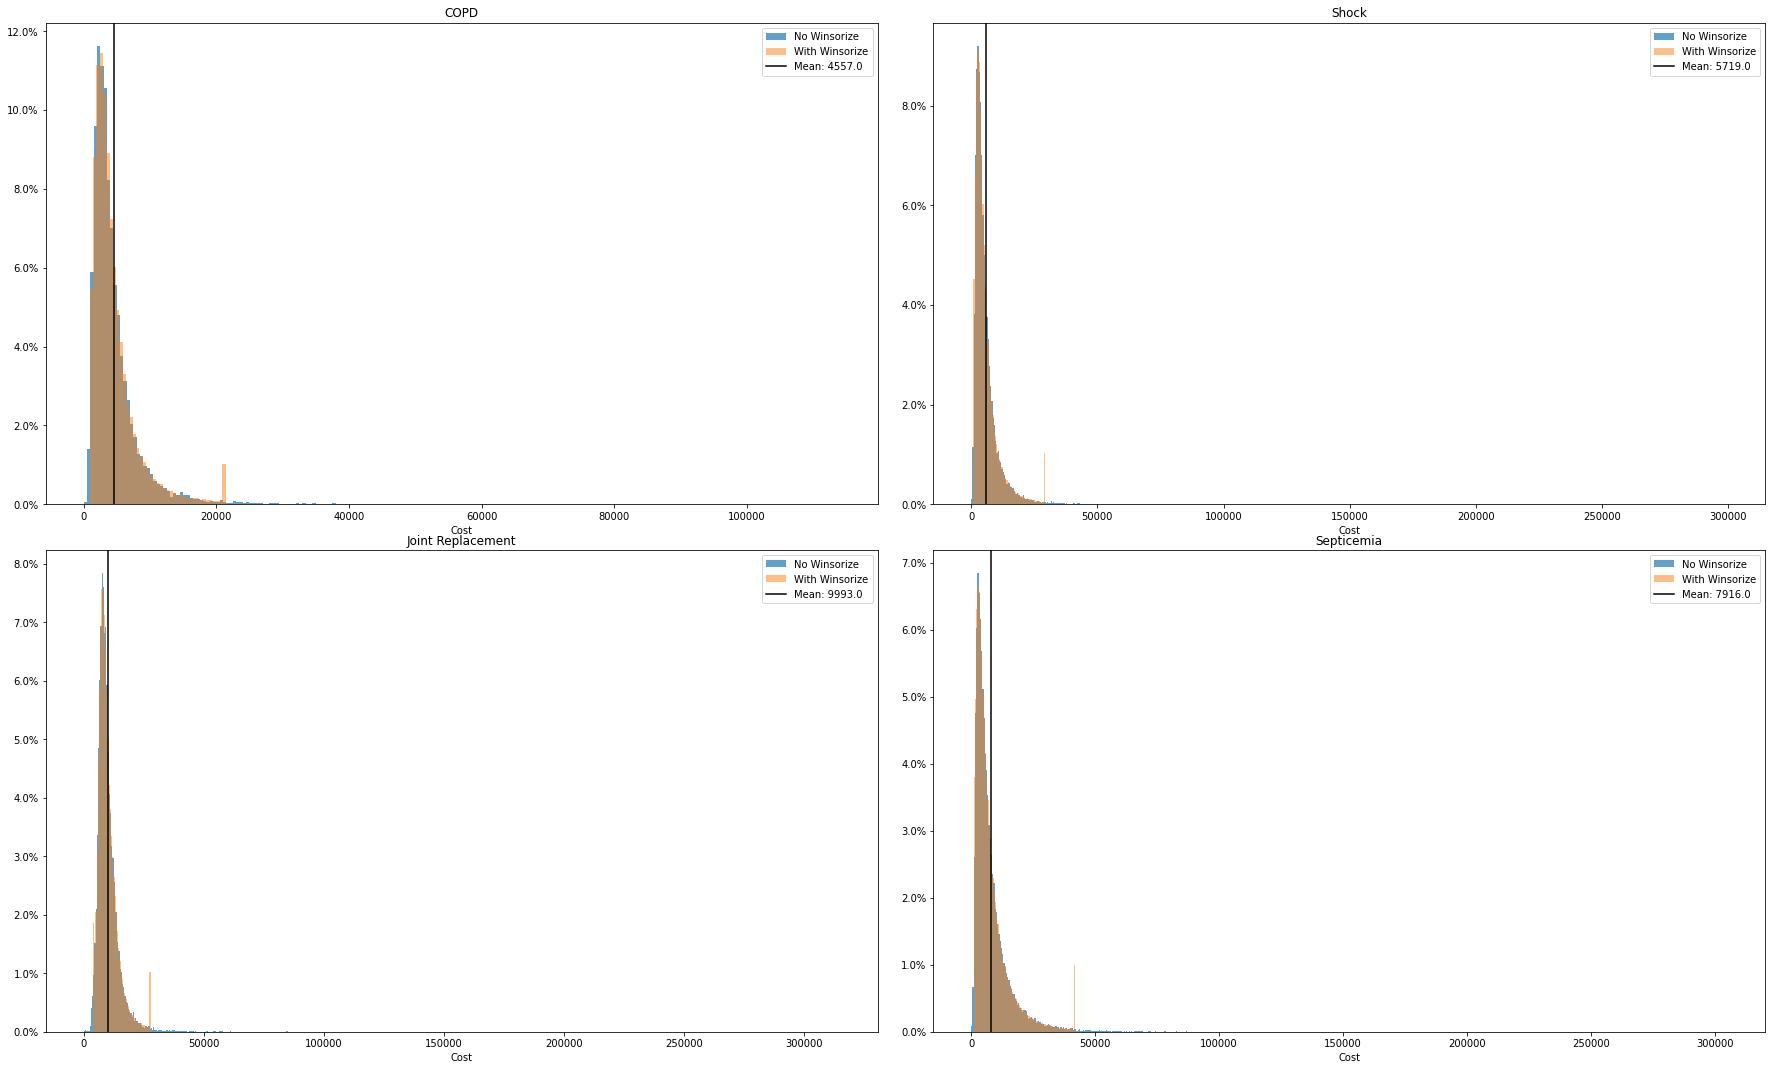

In [117]:
"""
Plotting each of the 4 groups for a finer view and a better understanding
of what each model will be up against.
"""

fig, axs = plt.subplots(2, 2, figsize=(25,15))
plt.tight_layout(pad=2.5)


#plotting COPD
copd_test_weights =  [1/len(y_test_copd)]*len(y_test_copd)
copd_weights = [1/len(y_train_copd)]*len(y_train_copd)
w = 500 #bin width
axs[0,0].hist(y_test_copd, alpha=0.7, weights=copd_test_weights, 
         bins=np.arange(min(y_test_copd), max(y_test_copd)+w, w), label="No Winsorize")
axs[0,0].hist(y_train_copd, alpha=0.5, weights=copd_weights, 
         bins=np.arange(min(y_train_copd), max(y_train_copd)+w, w), label='With Winsorize')
axs[0,0].set_title('COPD')
axs[0,0].set_xlabel('Cost')
axs[0,0].axvline(y_train_copd.mean(), color='black', label='Mean: '+str(np.round(y_train_copd.mean(),0)))
axs[0,0].legend(loc='upper right')
axs[0,0].yaxis.set_major_formatter(PercentFormatter(1))

#plotting Shock
shock_test_weights =  [1/len(y_test_shock)]*len(y_test_shock)
shock_weights = [1/len(y_train_shock)]*len(y_train_shock)
w = 500 #bin width
axs[0,1].hist(y_test_shock, alpha=0.7, weights=shock_test_weights, 
         bins=np.arange(min(y_test_shock), max(y_test_shock)+w, w), label="No Winsorize")
axs[0,1].hist(y_train_shock, alpha=0.5, weights=shock_weights, 
         bins=np.arange(min(y_train_shock), max(y_train_shock)+w, w), label='With Winsorize')
axs[0,1].set_title('Shock')
axs[0,1].set_xlabel('Cost')
axs[0,1].axvline(y_train_shock.mean(), color='black', label='Mean: '+str(np.round(y_train_shock.mean(),0)))
axs[0,1].legend(loc='upper right')
axs[0,1].yaxis.set_major_formatter(PercentFormatter(1))

#plotting joint replacement
joint_test_weights =  [1/len(y_test_joint)]*len(y_test_joint)
joint_weights = [1/len(y_train_joint)]*len(y_train_joint)
w = 500 #bin width
axs[1,0].hist(y_test_joint, alpha=0.7, weights=joint_test_weights, 
         bins=np.arange(min(y_test_joint), max(y_test_joint)+w, w), label="No Winsorize")
axs[1,0].hist(y_train_joint, alpha=0.5, weights=joint_weights, 
         bins=np.arange(min(y_train_joint), max(y_train_joint)+w, w), label='With Winsorize')
axs[1,0].set_title('Joint Replacement')
axs[1,0].set_xlabel('Cost')
axs[1,0].axvline(y_train_joint.mean(), color='black', label='Mean: '+str(np.round(y_train_joint.mean(),0)))
axs[1,0].legend(loc='upper right')
axs[1,0].yaxis.set_major_formatter(PercentFormatter(1))


#plotting Septicemia
sept_test_weights =  [1/len(y_test_sept)]*len(y_test_sept)
sept_weights = [1/len(y_train_sept)]*len(y_train_sept)
w = 500 #bin width
axs[1,1].hist(y_test_sept, alpha=0.7, weights=sept_test_weights, 
         bins=np.arange(min(y_test_sept), max(y_test_sept)+w, w), label="No Winsorize")
axs[1,1].hist(y_train_sept, alpha=0.5, weights=sept_weights, 
         bins=np.arange(min(y_train_sept), max(y_train_sept)+w, w), label='With Winsorize')
axs[1,1].set_title('Septicemia')
axs[1,1].set_xlabel('Cost')
axs[1,1].axvline(y_train_sept.mean(), color='black', label='Mean: '+str(np.round(y_train_sept.mean(),0)))
axs[1,1].legend(loc='upper right')
axs[1,1].yaxis.set_major_formatter(PercentFormatter(1))


plt.show()

## The models

Below are the models used for each of the case groups. For each case group there will first be the cost target, followed by the LOS target.

It was found do be beneficial to split the model up, having part of the model focus on just the diagnosis data and another part on just the demographic data. Then these models were frozen, put alongside each other and a third model was placed on top. The diagnosis model always outperformed the demographic model and frequently the combined model as well, but given the ease of training the extra models, it was easiest to follow this template for all case groups and then simply pick between the combined or just diagnosis model for that case group.

It was also found to be beneficial (both in terms of training time and in terms of error) to first train a generic model on all 4 case groups (though only using the data that would be used for specific models so as to not have any data leakage) and then use that model and its weights as the initialization for case group specific models; for the diagnosis models the first layer was left frozen. Keeping the first layer frozen boosted accuracy; I suspect that it did so, as it forced the model to keep data on rarer cases of patients that had symptoms from other case groups rather than just overwriting and ignoring them during retraining.

As you will see, the model uses fully connected layers, that are 5,000 neurons wide and use leaky ReLu to prevent dead neurons. The very wide layers was needed to fully capture the data, however it made the models very prone to overfitting, to deal with this a very high dropout rate (between 70% and 90%) worked best, resulting in loss function over epochs for both validation and training sets (mostly) moving nicely in tandem, as well as having smaller jumps in error on the final test set.

Epoch 1/50
2437/2437 [==============================] - 156s 63ms/step - loss: 6914.1011 - val_loss: 5055.0801
Epoch 2/50
2437/2437 [==============================] - 153s 63ms/step - loss: 4478.5732 - val_loss: 3447.0269
Epoch 3/50
2437/2437 [==============================] - 154s 63ms/step - loss: 3226.0945 - val_loss: 3163.7820
Epoch 4/50
2437/2437 [==============================] - 157s 64ms/step - loss: 3147.6077 - val_loss: 3144.1350
Epoch 5/50
2437/2437 [==============================] - 152s 62ms/step - loss: 3138.0793 - val_loss: 3154.8843
Epoch 6/50
2437/2437 [==============================] - 157s 64ms/step - loss: 3132.6755 - val_loss: 3136.3074
Epoch 7/50
2437/2437 [==============================] - 156s 64ms/step - loss: 3129.1990 - val_loss: 3134.6562
Epoch 8/50
2437/2437 [==============================] - 152s 62ms/step - loss: 3125.5457 - val_loss: 3137.7388
Epoch 9/50
4874/4874 [==============================] - 14s 3ms/step - loss: 3182.6760
model loss 3182.676025390

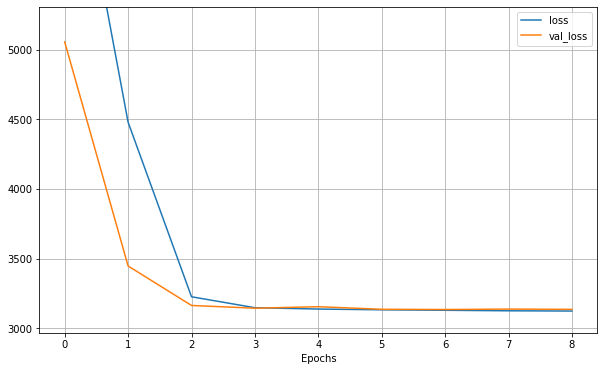

In [18]:
"""
Training a model using only the diagnosis data
"""

diag_X_train = X_train[:, :ds[1]]
diag_X_valid = X_valid[:, :ds[1]]
diag_X_test = X_test[:, :ds[1]]



leakyr = tf.keras.layers.LeakyReLU(alpha=0.01)
batch_taile = 512

layers = [keras.layers.InputLayer(input_shape=[int(ds[1]), ], name="input"),
          keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd, name='dense1'),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.7, name='drop1'),
          keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.7),
          keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.7),
          keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.7),
          keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.7),
          keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.7),
          keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.7),
          keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.7),
          keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.7),
          keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.7),
          keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.7),
          keras.layers.Dense(500, activation=leakyr, kernel_constraint=mnd),
          keras.layers.BatchNormalization(),
          keras.layers.Dense(1, name="output")]

diag_model = keras.models.Sequential(layers)

adam = keras.optimizers.Adam(learning_rate=0.0005)
diag_model.compile(loss="mean_absolute_error",
                    optimizer=adam#keras.optimizers.SGD(learning_rate=0.003),#0.01 is the default
                    )


"""
Using early stopping to avoid overfitting, and saving checkpoints;
"""

early_stop = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint("costs_model_cp.h5", save_best_only=True)
chistory = diag_model.fit(diag_X_train, y_train, epochs=50, batch_size=batch_taile,
                    validation_data=(diag_X_valid, y_valid), callbacks=[early_stop, checkpoint]
                   )
"""
getting results and plotting
"""
#getting results
print("model loss", diag_model.evaluate(diag_X_test, y_test))
preds = diag_model.predict(diag_X_test)
preds = np.asarray(preds).reshape(-1)
print('MAE:', mean_absolute_error(y_test, preds))

pd.DataFrame(chistory.history).plot(figsize=(10,6))
plt.grid(True)

loss_max = np.round(max(chistory.history['loss']), 4)
loss_min = np.round(min(chistory.history['loss']), 4)
val_max = np.round(max(chistory.history['val_loss']), 4)
val_min = np.round(min(chistory.history['val_loss']), 4)
#y_max = max(loss_max, val_max)+0.2
y_max = val_max+(0.05*val_max)
y_min = min(loss_min, val_min)-(.05*min(loss_min, val_min))
plt.gca().set_ylim(y_min, y_max)

plt.xlabel("Epochs")
"""
"""


plt.show()

In [104]:
#diag_model.save("diagnosis_model.h5")
diag_model = tf.keras.models.load_model('diagnosis_model.h5')

2022-04-26 17:32:12.245828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 17:32:12.246433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 17:32:12.246894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 17:32:12.247390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 17:32:12.247847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Epoch 1/50
2437/2437 [==============================] - 9s 3ms/step - loss: 7469.0532 - val_loss: 7446.0010
Epoch 2/50
2437/2437 [==============================] - 8s 3ms/step - loss: 7351.3423 - val_loss: 7281.4043
Epoch 3/50
2437/2437 [==============================] - 8s 3ms/step - loss: 7155.9043 - val_loss: 7049.0664
Epoch 4/50
2437/2437 [==============================] - 8s 3ms/step - loss: 6893.4004 - val_loss: 6754.0762
Epoch 5/50
2437/2437 [==============================] - 8s 3ms/step - loss: 6566.3105 - val_loss: 6335.9678
Epoch 6/50
2437/2437 [==============================] - 8s 3ms/step - loss: 6176.6328 - val_loss: 6003.3506
Epoch 7/50
2437/2437 [==============================] - 8s 3ms/step - loss: 5731.4697 - val_loss: 5513.2363
Epoch 8/50
2437/2437 [==============================] - 8s 3ms/step - loss: 5248.0488 - val_loss: 5036.7529
Epoch 9/50
2437/2437 [==============================] - 8s 3ms/step - loss: 4756.8828 - val_loss: 4540.1187
Epoch 10/50
2437/2437 [=====

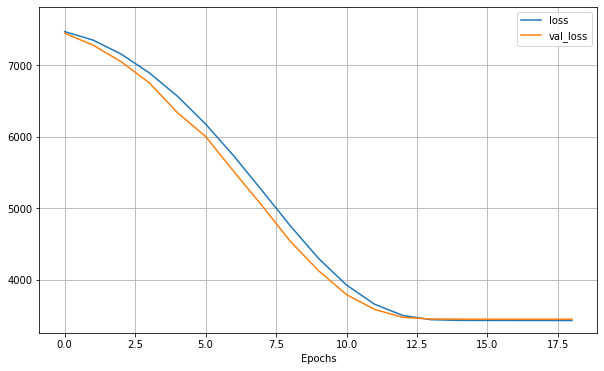

In [19]:
"""
Training a model using only the demographic data
"""

demo_X_train = X_train[:, ds[1]:-1]
demo_X_valid = X_valid[:, ds[1]:-1]
demo_X_test = X_test[:, ds[1]:-1]




leakyr = tf.keras.layers.LeakyReLU(alpha=0.01)
batch_taile = 512

layers = [keras.layers.InputLayer(input_shape=[int(demo_X_train.shape[1]), ], name="input"),
          keras.layers.Dense(600, activation=leakyr, kernel_constraint=mnd, name='dense1'),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.4, name='drop1'),
          keras.layers.Dense(600, activation=leakyr, kernel_constraint=mnd),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.4),
          keras.layers.Dense(600, activation=leakyr, kernel_constraint=mnd),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.4),
          keras.layers.Dense(600, activation=leakyr, kernel_constraint=mnd),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.4),
          keras.layers.Dense(600, activation=leakyr, kernel_constraint=mnd),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.4),
          keras.layers.Dense(500, activation=leakyr, kernel_constraint=mnd),
          keras.layers.BatchNormalization(),
          keras.layers.Dense(1, name="output")]

demo_model = keras.models.Sequential(layers)

adam = keras.optimizers.Adam(learning_rate=0.0001)
demo_model.compile(loss="mean_absolute_error",
                    optimizer=adam#keras.optimizers.SGD(learning_rate=0.003),#0.01 is the default
                    )


"""
Using early stopping to avoid overfitting, and saving checkpoints;
"""

early_stop = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint("costs_model_cp.h5", save_best_only=True)
chistory = demo_model.fit(demo_X_train, y_train, epochs=50, batch_size=batch_taile,
                    validation_data=(demo_X_valid, y_valid), callbacks=[early_stop, checkpoint]
                   )
"""
getting results and plotting
"""
#getting results
print("model loss", demo_model.evaluate(demo_X_test, y_test))
preds = demo_model.predict(demo_X_test)
preds = np.asarray(preds).reshape(-1)
print('MAE:', mean_absolute_error(y_test, preds))

pd.DataFrame(chistory.history).plot(figsize=(10,6))
plt.grid(True)

loss_max = np.round(max(chistory.history['loss']), 4)
loss_min = np.round(min(chistory.history['loss']), 4)
val_max = np.round(max(chistory.history['val_loss']), 4)
val_min = np.round(min(chistory.history['val_loss']), 4)
#y_max = max(loss_max, val_max)+0.2
y_max = val_max+(0.05*val_max)
y_min = min(loss_min, val_min)-(.05*min(loss_min, val_min))
plt.gca().set_ylim(y_min, y_max)

plt.xlabel("Epochs")
"""
"""
plt.show()

In [105]:
#demo_model.save("demographic_model.h5")
demo_model = tf.keras.models.load_model('demographic_model.h5')

Epoch 1/50
   7/4874 [..............................] - ETA: 1:47 - loss: 7488.9443 

2022-04-20 12:16:39.976829: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4874/4874 [==============================] - 116s 24ms/step - loss: 3896.4670 - val_loss: 3110.0803
Epoch 2/50
4874/4874 [==============================] - 114s 23ms/step - loss: 3118.2837 - val_loss: 3107.3604
Epoch 3/50
4874/4874 [==============================] - 114s 23ms/step - loss: 3115.3464 - val_loss: 3102.2124
Epoch 4/50
4874/4874 [==============================] - 111s 23ms/step - loss: 3113.7876 - val_loss: 3104.9756
Epoch 5/50
4874/4874 [==============================] - 20s 4ms/step - loss: 3148.3335
model loss 3148.33349609375
MAE: 3148.338


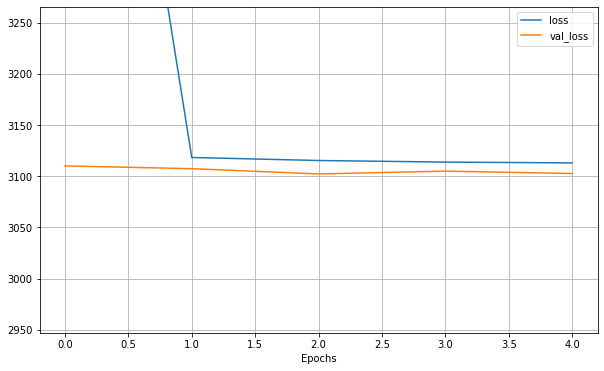

In [18]:
"""
now we will put the two halves together
"""

#redoing data as reminder
diag_X_train = X_train[:, :ds[1]]
diag_X_valid = X_valid[:, :ds[1]]
diag_X_test = X_test[:, :ds[1]]

demo_X_train = X_train[:, ds[1]:-1]
demo_X_valid = X_valid[:, ds[1]:-1]
demo_X_test = X_test[:, ds[1]:-1]



diag_clone = keras.models.clone_model(diag_model)
diag_clone.set_weights(diag_model.get_weights())
diag_clone = diag_clone.layers[:-5] #dropping the single output layer and its preceeding dropout layer
#freezing all layers except the very last
for l in diag_clone[:]:
    l.trainable = False
diag_clone = keras.models.Sequential(diag_clone)

demo_clone = keras.models.clone_model(demo_model)
demo_clone.set_weights(demo_model.get_weights())
demo_clone = demo_clone.layers[:-5] #dropping the single output layer and its preceeding dropout layer
#freezing all layers except the very last
for l in demo_clone[:]:
    l.trainable = False
demo_clone = keras.models.Sequential(demo_clone)


leakyr = tf.keras.layers.LeakyReLU(alpha=0.01)
batch_taile = 256

#sticking them together
diag_in = keras.Input(shape=[diag_X_train.shape[1],])
demo_in = keras.Input(shape=[demo_X_train.shape[1],])

diag = diag_clone(diag_in)
demo = demo_clone(demo_in)

concat = keras.layers.concatenate([diag, demo])

normalize = keras.layers.BatchNormalization()(concat)
drop = keras.layers.Dropout(0.9)(normalize)

h1 = keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd)(drop)
h2 = keras.layers.BatchNormalization()(h1)
h3 = keras.layers.Dropout(0.9, name='drop1')(h2)
h4 = keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd)(h3)
h5 = keras.layers.BatchNormalization()(h4)
h6 = keras.layers.Dropout(0.9)(h5)
h7 = keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd)(h6)
h8 = keras.layers.BatchNormalization()(h7)
h9 = keras.layers.Dropout(0.9)(h8)
h10 = keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd)(h9)
h11 = keras.layers.BatchNormalization()(h10)
out = keras.layers.Dense(1, activation=leakyr, name="output")(h11)


cmodel = keras.Model(inputs=[diag_in, demo_in], outputs=[out])

adam = keras.optimizers.Adam(learning_rate=0.0005)
huber_loss = tf.keras.losses.Huber(delta=1.0)
cmodel.compile(loss="mean_absolute_error",
              optimizer=adam#keras.optimizers.SGD(learning_rate=0.0005)
             )

"""
Using early stopping to avoid overfitting, and saving checkpoints;
"""

early_stop = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint("costs_model_cp.h5", save_best_only=True)
chistory = cmodel.fit((diag_X_train, demo_X_train), y_train, epochs=50, batch_size=batch_taile,
                    validation_data=((diag_X_valid, demo_X_valid), y_valid), callbacks=[early_stop, checkpoint]
                   )
"""
getting results and plotting
"""
#getting results
print("model loss", cmodel.evaluate((diag_X_test, demo_X_test), y_test))
preds = cmodel.predict((diag_X_test, demo_X_test))
preds = np.asarray(preds).reshape(-1)
print('MAE:', mean_absolute_error(y_test, preds))

pd.DataFrame(chistory.history).plot(figsize=(10,6))
plt.grid(True)

loss_max = np.round(max(chistory.history['loss']), 4)
loss_min = np.round(min(chistory.history['loss']), 4)
val_max = np.round(max(chistory.history['val_loss']), 4)
val_min = np.round(min(chistory.history['val_loss']), 4)
#y_max = max(loss_max, val_max)+0.2
y_max = val_max+(0.05*val_max)
y_min = min(loss_min, val_min)-(.05*min(loss_min, val_min))
plt.gca().set_ylim(y_min, y_max)

plt.xlabel("Epochs")
"""
"""
plt.show()

In [108]:
def clone_train_diagnosis_model(lr=0.003, batchsize=128, target="TotalDirectCost", 
                           num_frozen_layers=1, base_model=diag_model, patience=3,
                           diag_X_train=diag_X_train, diag_X_valid=diag_X_valid, diag_X_test=diag_X_test,
                           y_train=y_train, y_valid=y_valid, y_test=y_test):
    
    diag_clone = keras.models.clone_model(base_model)
    diag_clone.set_weights(base_model.get_weights())
    #freezing first dense layer(s), corresponding batch normalization, and dropout
    if num_frozen_layers>0:
        diag_clone = diag_clone.layers
        for l in diag_clone[:(num_frozen_layers*3)]:
            l.trainable = False
        diag_clone = keras.models.Sequential(diag_clone)
    
    diag_clone.compile(loss="mean_absolute_error",
                       optimizer=keras.optimizers.SGD(learning_rate=lr)
                      )
    early_stop = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    history = diag_clone.fit(diag_X_train, y_train, epochs=50, batch_size=batchsize,
                             validation_data=(diag_X_valid, y_valid), callbacks=[early_stop])
    
    """
    getting results and plotting
    """
    print("MAE", diag_clone.evaluate(diag_X_test, y_test))
    pd.DataFrame(history.history).plot(figsize=(10,6))
    plt.grid(True)
    loss_max = np.round(max(history.history['loss']), 4)
    loss_min = np.round(min(history.history['loss']), 4)
    val_max = np.round(max(history.history['val_loss']), 4)
    val_min = np.round(min(history.history['val_loss']), 4)
    y_max = val_max+(0.05*val_max)
    y_min = min(loss_min, val_min)-(.05*min(loss_min, val_min))
    plt.gca().set_ylim(y_min, y_max)
    plt.xlabel("Epochs")
    plt.show()
    
    return diag_clone




def clone_train_demographic_model(lr=0.0001, batchsize=128, target="TotalDirectCost", 
                                  num_frozen_layers=1, base_model=demo_model, patience=3,
                                  demo_X_train=demo_X_train, demo_X_valid=demo_X_valid, demo_X_test=demo_X_test,
                                  y_train=y_train, y_valid=y_valid, y_test=y_test):
    
    demo_clone = keras.models.clone_model(demo_model)
    demo_clone.set_weights(demo_model.get_weights())
    #freezing layers
    if num_frozen_layers>0:
        demo_clone = demo_clone.layers
        for l in demo_clone[:(num_frozen_layers*3)+1]:
            l.trainable = False
        demo_clone = keras.models.Sequential(demo_clone)
    
    adam = keras.optimizers.Adam(learning_rate=lr)
    demo_clone.compile(loss="mean_absolute_error", optimizer=adam)
    early_stop = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    history = demo_clone.fit(demo_X_train, y_train, epochs=50, batch_size=batchsize,
                             validation_data=(demo_X_valid, y_valid), callbacks=[early_stop])
    
    """
    getting results and plotting
    """
    print("MAE", demo_clone.evaluate(demo_X_test, y_test))
    pd.DataFrame(history.history).plot(figsize=(10,6))
    plt.grid(True)
    loss_max = np.round(max(history.history['loss']), 4)
    loss_min = np.round(min(history.history['loss']), 4)
    val_max = np.round(max(history.history['val_loss']), 4)
    val_min = np.round(min(history.history['val_loss']), 4)
    y_max = val_max+(0.05*val_max)
    y_min = min(loss_min, val_min)-(.05*min(loss_min, val_min))
    plt.gca().set_ylim(y_min, y_max)
    plt.xlabel("Epochs")
    plt.show()
    return demo_clone


def mate_both_models_together(lr=0.0002, batchsize=128, num_unfrozen_layers=0, patience=3,
                              cloned_diag_model=diag_model, cloned_demo_model=demo_model,
                              diag_X_train=diag_X_train, diag_X_valid=diag_X_valid, diag_X_test=diag_X_test,
                              demo_X_train=demo_X_train, demo_X_valid=demo_X_valid, demo_X_test=demo_X_test,
                              y_train=y_train, y_valid=y_valid, y_test=y_test):
    
    diag_clone = cloned_diag_model.layers[:-5] #dropping the single output layer and its preceeding dropout layer
    #freezing layers
    for l in diag_clone[:]:
            l.trainable = False
    diag_clone = keras.models.Sequential(diag_clone)

    demo_clone = cloned_demo_model.layers[:-5] #dropping the single output layer and its preceeding dropout layer
    for l in demo_clone[:]:
            l.trainable = False
    demo_clone = keras.models.Sequential(cloned_demo_model)


    leakyr = tf.keras.layers.LeakyReLU(alpha=0.01)
    
    #sticking them together
    diag_in = keras.Input(shape=[diag_X_train.shape[1],])
    demo_in = keras.Input(shape=[demo_X_train.shape[1],])

    diag = diag_clone(diag_in)
    demo = demo_clone(demo_in)

    concat = keras.layers.concatenate([diag, demo])

    normalize = keras.layers.BatchNormalization()(concat)
    drop = keras.layers.Dropout(0.9)(normalize)

    h1 = keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd)(drop)
    h2 = keras.layers.BatchNormalization()(h1)
    h3 = keras.layers.Dropout(0.9, name='drop1')(h2)
    h4 = keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd)(h3)
    h5 = keras.layers.BatchNormalization()(h4)
    h6 = keras.layers.Dropout(0.9)(h5)
    h7 = keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd)(h6)
    h8 = keras.layers.BatchNormalization()(h7)
    h9 = keras.layers.Dropout(0.9)(h8)
    h10 = keras.layers.Dense(5000, activation=leakyr, kernel_constraint=mnd)(h9)
    h11 = keras.layers.BatchNormalization()(h10)
    out = keras.layers.Dense(1, activation=leakyr, name="output")(h11)


    combined_model = keras.Model(inputs=[diag_in, demo_in], outputs=[out])
    adam = keras.optimizers.Adam(learning_rate=lr)
    combined_model.compile(loss="mean_absolute_error", optimizer=adam)
    early_stop = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    history = combined_model.fit((diag_X_train, demo_X_train), y_train, epochs=50, batch_size=batchsize,
                                  validation_data=((diag_X_valid, demo_X_valid), y_valid), callbacks=[early_stop])
    
    """
    getting results and plotting
    """
    #getting results
    print("MAE", combined_model.evaluate((diag_X_test, demo_X_test), y_test))
    pd.DataFrame(history.history).plot(figsize=(10,6))
    plt.grid(True)
    loss_max = np.round(max(history.history['loss']), 4)
    loss_min = np.round(min(history.history['loss']), 4)
    val_max = np.round(max(history.history['val_loss']), 4)
    val_min = np.round(min(history.history['val_loss']), 4)
    y_max = val_max+(0.05*val_max)
    y_min = min(loss_min, val_min)-(.05*min(loss_min, val_min))
    plt.gca().set_ylim(y_min, y_max)
    plt.xlabel("Epochs")
    plt.show()
    
    
    return combined_model

# COPD

(112861, 544)
(14108, 544)
CLONING DIAGNOSIS MODEL
Epoch 1/50
882/882 [==============================] - 24s 26ms/step - loss: 2071.7346 - val_loss: 1976.5132
Epoch 2/50
882/882 [==============================] - 22s 25ms/step - loss: 1977.2073 - val_loss: 1966.5205
Epoch 3/50
882/882 [==============================] - 22s 25ms/step - loss: 1973.9647 - val_loss: 1965.1294
Epoch 4/50
882/882 [==============================] - 22s 25ms/step - loss: 1971.2411 - val_loss: 1966.4557
Epoch 5/50
882/882 [==============================] - 21s 24ms/step - loss: 1970.0736 - val_loss: 1967.5094
Epoch 6/50
441/441 [==============================] - 1s 3ms/step - loss: 1963.2094
MAE 1963.2093505859375


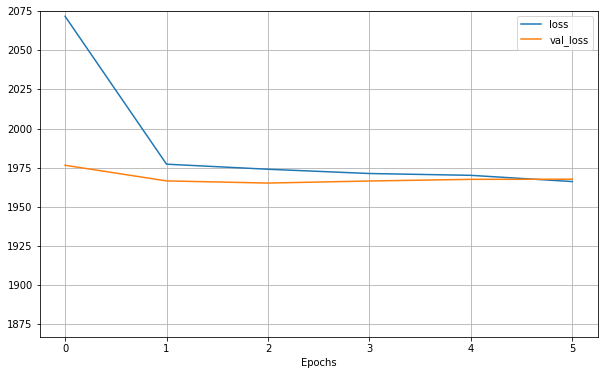

CLONING DEMOGRAPHIC MODEL
Epoch 1/50
441/441 [==============================] - 2s 3ms/step - loss: 2708.9084 - val_loss: 2493.9656
Epoch 2/50
441/441 [==============================] - 1s 3ms/step - loss: 2408.8508 - val_loss: 2302.7700
Epoch 3/50
441/441 [==============================] - 1s 3ms/step - loss: 2246.4636 - val_loss: 2188.6084
Epoch 4/50
441/441 [==============================] - 1s 3ms/step - loss: 2163.4060 - val_loss: 2145.1387
Epoch 5/50
441/441 [==============================] - 1s 3ms/step - loss: 2127.9937 - val_loss: 2126.3181
Epoch 6/50
441/441 [==============================] - 1s 3ms/step - loss: 2118.7273 - val_loss: 2123.5630
Epoch 7/50
441/441 [==============================] - 1s 3ms/step - loss: 2115.3367 - val_loss: 2124.9287
Epoch 8/50
441/441 [==============================] - 1s 3ms/step - loss: 2114.6030 - val_loss: 2123.2981
Epoch 9/50
441/441 [==============================] - 1s 3ms/step - loss: 2114.5625 - val_loss: 2123.0002
Epoch 10/50
441/441 

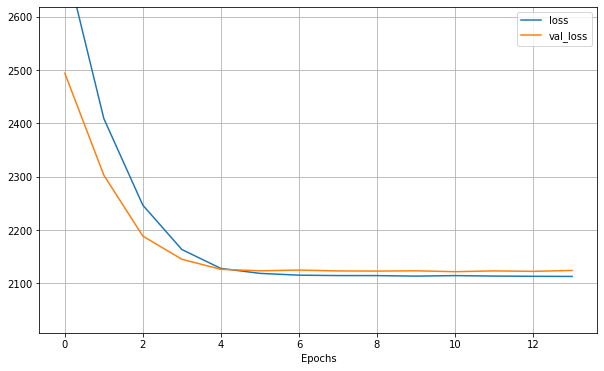

COMBINING BOTH MODELS FOR FINAL MODEL
Epoch 1/50
882/882 [==============================] - 19s 19ms/step - loss: 4166.0005 - val_loss: 3645.5884
Epoch 2/50
882/882 [==============================] - 16s 18ms/step - loss: 3254.7637 - val_loss: 2761.8650
Epoch 3/50
882/882 [==============================] - 16s 18ms/step - loss: 2558.7402 - val_loss: 2356.6704
Epoch 4/50
882/882 [==============================] - 16s 18ms/step - loss: 2332.7297 - val_loss: 2220.9797
Epoch 5/50
882/882 [==============================] - 16s 18ms/step - loss: 2256.0452 - val_loss: 2183.3772
Epoch 6/50
882/882 [==============================] - 16s 18ms/step - loss: 2210.6997 - val_loss: 2150.8086
Epoch 7/50
882/882 [==============================] - 16s 18ms/step - loss: 2132.7849 - val_loss: 2044.6555
Epoch 8/50
882/882 [==============================] - 16s 18ms/step - loss: 2059.6687 - val_loss: 2005.7723
Epoch 9/50
882/882 [==============================] - 16s 18ms/step - loss: 2036.4641 - val_loss: 

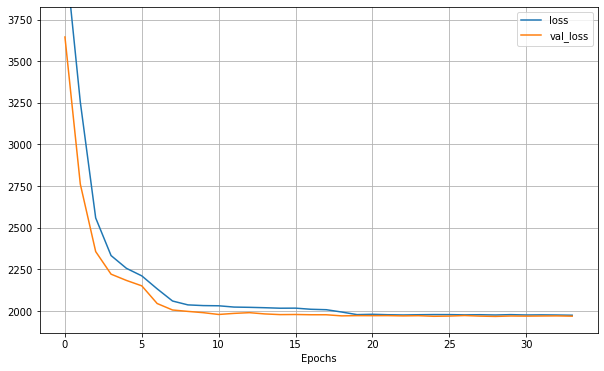

In [20]:
"""
Sub group codes:
65==COPD
101==HF/Shock
152==Maj. joint replacement
294==Septicemia

targets==["TotalDirectCost", "DeathFlag", "LOS"]
"""

X_train, X_valid, X_test, y_train, y_valid, y_test, ds = prep_data(group=65, target='TotalDirectCost', 
                                                      data=data, ids=ids, raw_tdf=raw_tdf)



X_age_train = X_train[:, -1:]
X_age_valid = X_valid[:, -1:]
X_age_test = X_test[:, -1:]

X_train = X_train[:, :-1]
X_valid = X_valid[:, :-1]
X_test = X_test[:, :-1]

diag_X_train = X_train[:, :ds[1]]
diag_X_valid = X_valid[:, :ds[1]]
diag_X_test = X_test[:, :ds[1]]

demo_X_train = X_train[:, ds[1]:-1]
demo_X_valid = X_valid[:, ds[1]:-1]
demo_X_test = X_test[:, ds[1]:-1]

print(X_train.shape)
print(X_valid.shape)


print('CLONING DIAGNOSIS MODEL')
copd_diag = clone_train_diagnosis_model(lr=0.003, batchsize=128, target="TotalDirectCost", 
                                        num_frozen_layers=1, base_model=diag_model, patience=3,
                                        diag_X_train=diag_X_train, diag_X_valid=diag_X_valid, diag_X_test=diag_X_test,
                                        y_train=y_train, y_valid=y_valid, y_test=y_test)
print('CLONING DEMOGRAPHIC MODEL')
copd_demo = clone_train_demographic_model(lr=0.0005, batchsize=128, 
                                          num_frozen_layers=1, base_model=demo_model, patience=3,
                                          demo_X_train=demo_X_train, demo_X_valid=demo_X_valid, demo_X_test=demo_X_test,
                                          y_train=y_train, y_valid=y_valid, y_test=y_test)
print('COMBINING BOTH MODELS FOR FINAL MODEL')
copd_cost_model = mate_both_models_together(lr=0.0002, batchsize=128,  patience=5,
                                            cloned_diag_model=copd_diag, 
                                            cloned_demo_model=copd_demo,
                                            diag_X_train=diag_X_train, diag_X_valid=diag_X_valid, 
                                            diag_X_test=diag_X_test, demo_X_train=demo_X_train, 
                                            demo_X_valid=demo_X_valid, demo_X_test=demo_X_test,
                                            y_train=y_train, y_valid=y_valid, y_test=y_test)


#OG was: 2171; LR 2044; RF 2138

(112861, 544)
(14108, 544)
CLONING DIAGNOSIS MODEL
Epoch 1/50
882/882 [==============================] - 24s 25ms/step - loss: 1199.7186 - val_loss: 82.1218
Epoch 2/50
882/882 [==============================] - 21s 24ms/step - loss: 43.2439 - val_loss: 23.6417
Epoch 3/50
882/882 [==============================] - 21s 24ms/step - loss: 11.6363 - val_loss: 2.7448
Epoch 4/50
882/882 [==============================] - 21s 24ms/step - loss: 3.8554 - val_loss: 2.0989
Epoch 5/50
882/882 [==============================] - 21s 24ms/step - loss: 3.1260 - val_loss: 1.9106
Epoch 6/50
882/882 [==============================] - 21s 24ms/step - loss: 2.6796 - val_loss: 1.9119
Epoch 7/50
882/882 [==============================] - 22s 25ms/step - loss: 2.4091 - val_loss: 1.9393
Epoch 8/50
441/441 [==============================] - 1s 3ms/step - loss: 1.9032
MAE 1.903205394744873


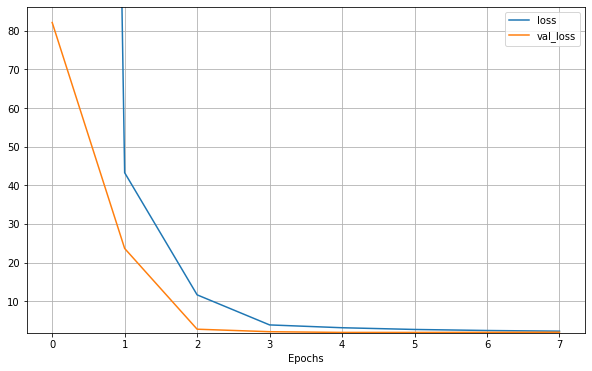

CLONING DEMOGRAPHIC MODEL
Epoch 1/50
221/221 [==============================] - 2s 4ms/step - loss: 5646.8389 - val_loss: 5282.4155
Epoch 2/50
221/221 [==============================] - 1s 3ms/step - loss: 4947.8809 - val_loss: 4418.8403
Epoch 3/50
221/221 [==============================] - 1s 3ms/step - loss: 4314.5786 - val_loss: 4052.5256
Epoch 4/50
221/221 [==============================] - 1s 3ms/step - loss: 3742.1968 - val_loss: 3439.3809
Epoch 5/50
221/221 [==============================] - 1s 3ms/step - loss: 3226.3911 - val_loss: 3112.5149
Epoch 6/50
221/221 [==============================] - 1s 3ms/step - loss: 2763.1821 - val_loss: 2523.8386
Epoch 7/50
221/221 [==============================] - 1s 3ms/step - loss: 2348.8992 - val_loss: 2146.4475
Epoch 8/50
221/221 [==============================] - 1s 3ms/step - loss: 1980.1409 - val_loss: 1852.0864
Epoch 9/50
221/221 [==============================] - 1s 3ms/step - loss: 1653.7144 - val_loss: 1506.1166
Epoch 10/50
221/221 

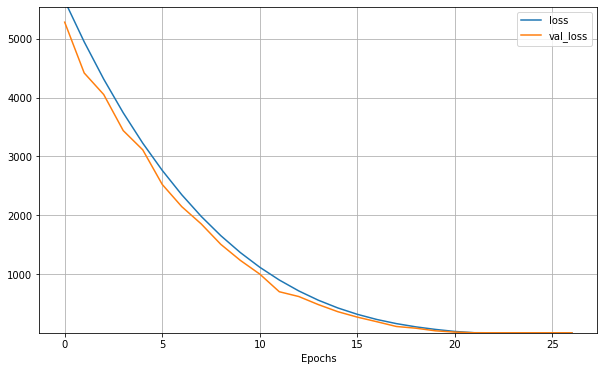

COMBINING BOTH MODELS FOR FINAL MODEL
Epoch 1/50
882/882 [==============================] - 18s 18ms/step - loss: 2.6857 - val_loss: 2.0919
Epoch 2/50
882/882 [==============================] - 15s 18ms/step - loss: 2.0239 - val_loss: 1.9303
Epoch 3/50
882/882 [==============================] - 15s 17ms/step - loss: 1.9624 - val_loss: 1.9136
Epoch 4/50
882/882 [==============================] - 14s 16ms/step - loss: 1.9423 - val_loss: 1.9377
Epoch 5/50
882/882 [==============================] - 14s 16ms/step - loss: 1.9347 - val_loss: 1.9406
Epoch 6/50
882/882 [==============================] - 14s 16ms/step - loss: 1.9298 - val_loss: 1.9199
Epoch 7/50
882/882 [==============================] - 15s 17ms/step - loss: 1.9313 - val_loss: 1.8931
Epoch 8/50
882/882 [==============================] - 14s 16ms/step - loss: 1.9242 - val_loss: 1.9295
Epoch 9/50
882/882 [==============================] - 15s 17ms/step - loss: 1.9297 - val_loss: 1.9773
Epoch 10/50
882/882 [=======================

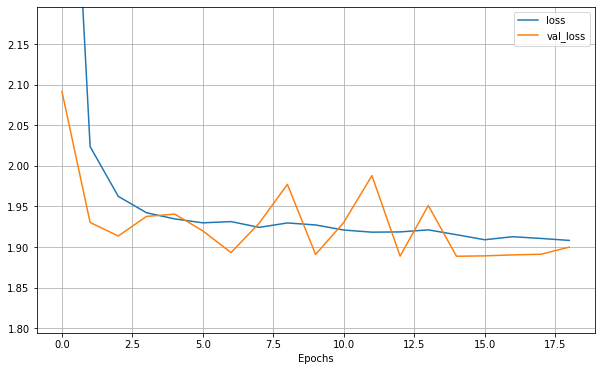

In [22]:
"""
Sub group codes:
65==COPD
101==HF/Shock
152==Maj. joint replacement
294==Septicemia

targets==["TotalDirectCost", "DeathFlag", "LOS"]
"""

X_train, X_valid, X_test, y_train, y_valid, y_test, ds = prep_data(group=65, target='LOS', 
                                                      data=data, ids=ids, raw_tdf=raw_tdf)



X_age_train = X_train[:, -1:]
X_age_valid = X_valid[:, -1:]
X_age_test = X_test[:, -1:]

X_train = X_train[:, :-1]
X_valid = X_valid[:, :-1]
X_test = X_test[:, :-1]

diag_X_train = X_train[:, :ds[1]]
diag_X_valid = X_valid[:, :ds[1]]
diag_X_test = X_test[:, :ds[1]]

demo_X_train = X_train[:, ds[1]:-1]
demo_X_valid = X_valid[:, ds[1]:-1]
demo_X_test = X_test[:, ds[1]:-1]

print(X_train.shape)
print(X_valid.shape)


print('CLONING DIAGNOSIS MODEL')
copd_diag = clone_train_diagnosis_model(lr=0.003, batchsize=128, target="LOS", 
                                        num_frozen_layers=1, base_model=diag_model, patience=3,
                                        diag_X_train=diag_X_train, diag_X_valid=diag_X_valid, diag_X_test=diag_X_test,
                                        y_train=y_train, y_valid=y_valid, y_test=y_test)
print('CLONING DEMOGRAPHIC MODEL')
copd_demo = clone_train_demographic_model(lr=0.001, batchsize=128, 
                                          num_frozen_layers=0, base_model=demo_model, patience=3,
                                          demo_X_train=demo_X_train, demo_X_valid=demo_X_valid, demo_X_test=demo_X_test,
                                          y_train=y_train, y_valid=y_valid, y_test=y_test)
print('COMBINING BOTH MODELS FOR FINAL MODEL')
copd_los_model = mate_both_models_together(lr=0.0002, batchsize=128,  patience=4,
                                            cloned_diag_model=copd_diag, 
                                            cloned_demo_model=copd_demo,
                                            diag_X_train=diag_X_train, diag_X_valid=diag_X_valid, 
                                            diag_X_test=diag_X_test, demo_X_train=demo_X_train, 
                                            demo_X_valid=demo_X_valid, demo_X_test=demo_X_test,
                                            y_train=y_train, y_valid=y_valid, y_test=y_test)


#OG was: 1.91; LR 1.9; RF 1.96

# Sepsis

(556322, 544)
(69540, 544)
CLONING DIAGNOSIS MODEL
Epoch 1/50
2174/2174 [==============================] - 71s 32ms/step - loss: 3752.5396 - val_loss: 3715.3562
Epoch 2/50
2174/2174 [==============================] - 68s 31ms/step - loss: 3742.0515 - val_loss: 3717.2224
Epoch 3/50
2174/2174 [==============================] - 69s 32ms/step - loss: 3736.8943 - val_loss: 3713.3687
Epoch 4/50
2174/2174 [==============================] - 69s 32ms/step - loss: 3737.8691 - val_loss: 3710.5652
Epoch 5/50
2174/2174 [==============================] - 68s 31ms/step - loss: 3735.4119 - val_loss: 3711.8137
Epoch 6/50
2174/2174 [==============================] - 69s 32ms/step - loss: 3735.3779 - val_loss: 3713.8096
Epoch 7/50
2174/2174 [==============================] - 68s 31ms/step - loss: 3735.7539 - val_loss: 3709.6267
Epoch 8/50
2174/2174 [==============================] - 68s 31ms/step - loss: 3734.1233 - val_loss: 3710.3599
Epoch 9/50
2174/2174 [==============================] - 68s 31ms/step

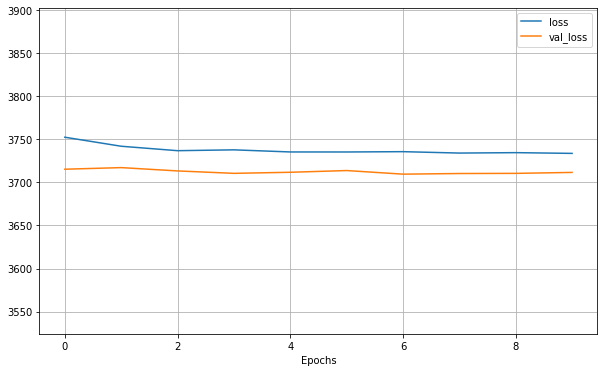

CLONING DEMOGRAPHIC MODEL
Epoch 1/50
1087/1087 [==============================] - 5s 3ms/step - loss: 4339.7119 - val_loss: 4332.6211
Epoch 2/50
1087/1087 [==============================] - 4s 3ms/step - loss: 4337.0767 - val_loss: 4333.0815
Epoch 3/50
1087/1087 [==============================] - 4s 3ms/step - loss: 4336.0020 - val_loss: 4331.5332
Epoch 4/50
1087/1087 [==============================] - 4s 3ms/step - loss: 4336.0293 - val_loss: 4333.9360
Epoch 5/50
1087/1087 [==============================] - 4s 3ms/step - loss: 4335.2227 - val_loss: 4334.3169
Epoch 6/50
2174/2174 [==============================] - 2s 999us/step - loss: 4411.3608
MAE 4411.36083984375


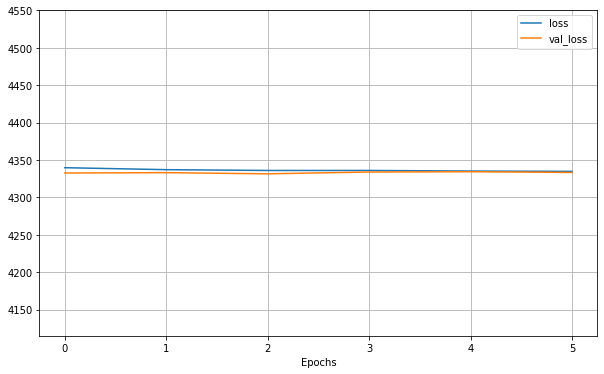

COMBINING BOTH MODELS FOR FINAL MODEL
Epoch 1/50
2174/2174 [==============================] - 54s 24ms/step - loss: 6795.7036 - val_loss: 5483.1226
Epoch 2/50
2174/2174 [==============================] - 51s 23ms/step - loss: 4759.1782 - val_loss: 4244.1997
Epoch 3/50
2174/2174 [==============================] - 51s 23ms/step - loss: 4019.1455 - val_loss: 3726.6006
Epoch 4/50
2174/2174 [==============================] - 51s 23ms/step - loss: 3816.8555 - val_loss: 3713.6411
Epoch 5/50
2174/2174 [==============================] - 49s 23ms/step - loss: 3776.1943 - val_loss: 3716.0603
Epoch 6/50
2174/2174 [==============================] - 50s 23ms/step - loss: 3755.8994 - val_loss: 3715.3970
Epoch 7/50
2174/2174 [==============================] - 50s 23ms/step - loss: 3751.8533 - val_loss: 3710.0811
Epoch 8/50
2174/2174 [==============================] - 50s 23ms/step - loss: 3751.2747 - val_loss: 3712.8037
Epoch 9/50
2174/2174 [==============================] - 51s 24ms/step - loss: 3749

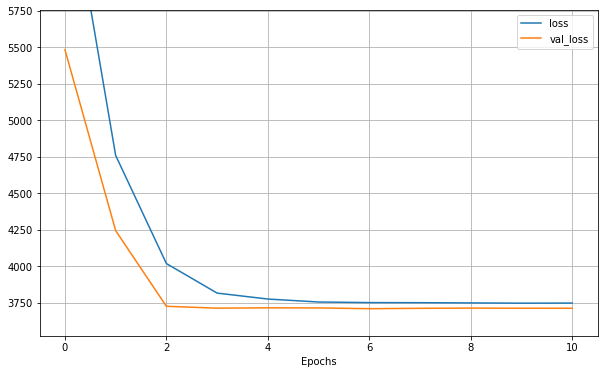

In [23]:
"""
Sub group codes:
65==COPD
101==HF/Shock
152==Maj. joint replacement
294==Septicemia

targets==["TotalDirectCost", "DeathFlag", "LOS"]
"""

X_train, X_valid, X_test, y_train, y_valid, y_test, ds = prep_data(group=294, target='TotalDirectCost', 
                                                      data=data, ids=ids, raw_tdf=raw_tdf)



X_age_train = X_train[:, -1:]
X_age_valid = X_valid[:, -1:]
X_age_test = X_test[:, -1:]

X_train = X_train[:, :-1]
X_valid = X_valid[:, :-1]
X_test = X_test[:, :-1]

diag_X_train = X_train[:, :ds[1]]
diag_X_valid = X_valid[:, :ds[1]]
diag_X_test = X_test[:, :ds[1]]

demo_X_train = X_train[:, ds[1]:-1]
demo_X_valid = X_valid[:, ds[1]:-1]
demo_X_test = X_test[:, ds[1]:-1]

print(X_train.shape)
print(X_valid.shape)


print('CLONING DIAGNOSIS MODEL')
sept_diag = clone_train_diagnosis_model(lr=0.003, batchsize=256, target="TotalDirectCost", 
                                        num_frozen_layers=1, base_model=diag_model, patience=3,
                                        diag_X_train=diag_X_train, diag_X_valid=diag_X_valid, diag_X_test=diag_X_test,
                                        y_train=y_train, y_valid=y_valid, y_test=y_test)
print('CLONING DEMOGRAPHIC MODEL')
sept_demo = clone_train_demographic_model(lr=0.001, batchsize=256, 
                                          num_frozen_layers=0, base_model=demo_model, patience=3,
                                          demo_X_train=demo_X_train, demo_X_valid=demo_X_valid, demo_X_test=demo_X_test,
                                          y_train=y_train, y_valid=y_valid, y_test=y_test)
print('COMBINING BOTH MODELS FOR FINAL MODEL')
sept_cost_model = mate_both_models_together(lr=0.0002, batchsize=256,  patience=4,
                                            cloned_diag_model=sept_diag, 
                                            cloned_demo_model=sept_demo,
                                            diag_X_train=diag_X_train, diag_X_valid=diag_X_valid, 
                                            diag_X_test=diag_X_test, demo_X_train=demo_X_train, 
                                            demo_X_valid=demo_X_valid, demo_X_test=demo_X_test,
                                            y_train=y_train, y_valid=y_valid, y_test=y_test)


#OG was: 3940; RF=4118, linear=4011

(556322, 544)
(69540, 544)
CLONING DIAGNOSIS MODEL
Epoch 1/50
2174/2174 [==============================] - 73s 33ms/step - loss: 382.2472 - val_loss: 3.3296
Epoch 2/50
2174/2174 [==============================] - 71s 33ms/step - loss: 4.1454 - val_loss: 3.1390
Epoch 3/50
2174/2174 [==============================] - 73s 33ms/step - loss: 3.4558 - val_loss: 3.0842
Epoch 4/50
2174/2174 [==============================] - 72s 33ms/step - loss: 3.2602 - val_loss: 3.0767
Epoch 5/50
2174/2174 [==============================] - 72s 33ms/step - loss: 3.1829 - val_loss: 3.1200
Epoch 6/50
2174/2174 [==============================] - 72s 33ms/step - loss: 3.1427 - val_loss: 3.0655
Epoch 7/50
2174/2174 [==============================] - 71s 33ms/step - loss: 3.1186 - val_loss: 3.1120
Epoch 8/50
2174/2174 [==============================] - 72s 33ms/step - loss: 3.1022 - val_loss: 3.1143
Epoch 9/50
2174/2174 [==============================] - 6s 3ms/step - loss: 3.0952
MAE 3.0952072143554688


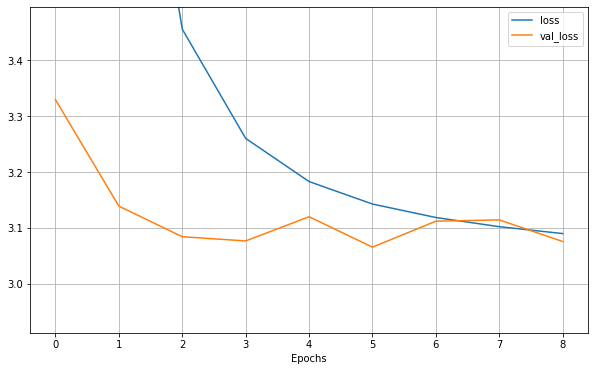

CLONING DEMOGRAPHIC MODEL
Epoch 1/50
2174/2174 [==============================] - 8s 3ms/step - loss: 3229.1492 - val_loss: 1249.8236
Epoch 2/50
2174/2174 [==============================] - 7s 3ms/step - loss: 481.9073 - val_loss: 56.1430
Epoch 3/50
2174/2174 [==============================] - 7s 3ms/step - loss: 6.9006 - val_loss: 3.4344
Epoch 4/50
2174/2174 [==============================] - 7s 3ms/step - loss: 3.4322 - val_loss: 3.3794
Epoch 5/50
2174/2174 [==============================] - 7s 3ms/step - loss: 3.4236 - val_loss: 3.5323
Epoch 6/50
2174/2174 [==============================] - 7s 3ms/step - loss: 3.4230 - val_loss: 3.3713
Epoch 7/50
2174/2174 [==============================] - 7s 3ms/step - loss: 3.4137 - val_loss: 3.3579
Epoch 8/50
2174/2174 [==============================] - 7s 3ms/step - loss: 3.4076 - val_loss: 3.3318
Epoch 9/50
2174/2174 [==============================] - 7s 3ms/step - loss: 3.4055 - val_loss: 3.3654
Epoch 10/50
2174/2174 [========================

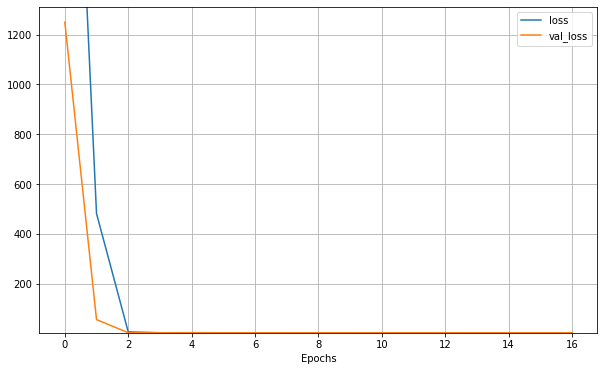

COMBINING BOTH MODELS FOR FINAL MODEL
Epoch 1/50
2174/2174 [==============================] - 55s 24ms/step - loss: 3.4947 - val_loss: 3.1768
Epoch 2/50
2174/2174 [==============================] - 52s 24ms/step - loss: 3.1628 - val_loss: 3.1049
Epoch 3/50
2174/2174 [==============================] - 53s 24ms/step - loss: 3.1352 - val_loss: 3.0951
Epoch 4/50
2174/2174 [==============================] - 53s 24ms/step - loss: 3.1263 - val_loss: 3.0948
Epoch 5/50
2174/2174 [==============================] - 53s 24ms/step - loss: 3.1214 - val_loss: 3.0866
Epoch 6/50
2174/2174 [==============================] - 53s 24ms/step - loss: 3.1212 - val_loss: 3.0884
Epoch 7/50
2174/2174 [==============================] - 53s 24ms/step - loss: 3.1154 - val_loss: 3.0676
Epoch 8/50
2174/2174 [==============================] - 52s 24ms/step - loss: 3.1164 - val_loss: 3.0800
Epoch 9/50
2174/2174 [==============================] - 53s 24ms/step - loss: 3.1090 - val_loss: 3.0739
Epoch 10/50
2174/2174 [===

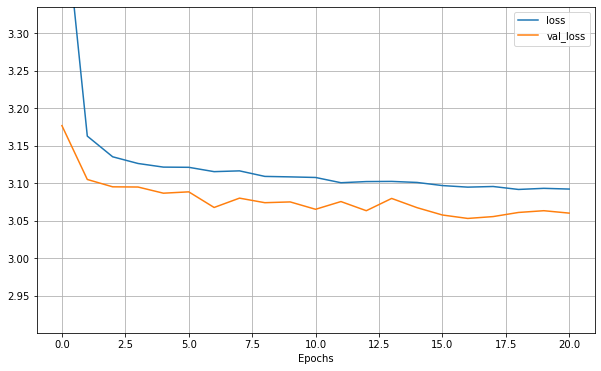

In [25]:
"""
Sub group codes:
65==COPD
101==HF/Shock
152==Maj. joint replacement
294==Septicemia

targets==["TotalDirectCost", "DeathFlag", "LOS"]
"""

X_train, X_valid, X_test, y_train, y_valid, y_test, ds = prep_data(group=294, target='LOS', 
                                                      data=data, ids=ids, raw_tdf=raw_tdf)



X_age_train = X_train[:, -1:]
X_age_valid = X_valid[:, -1:]
X_age_test = X_test[:, -1:]

X_train = X_train[:, :-1]
X_valid = X_valid[:, :-1]
X_test = X_test[:, :-1]

diag_X_train = X_train[:, :ds[1]]
diag_X_valid = X_valid[:, :ds[1]]
diag_X_test = X_test[:, :ds[1]]

demo_X_train = X_train[:, ds[1]:-1]
demo_X_valid = X_valid[:, ds[1]:-1]
demo_X_test = X_test[:, ds[1]:-1]

print(X_train.shape)
print(X_valid.shape)


print('CLONING DIAGNOSIS MODEL')
sept_diag = clone_train_diagnosis_model(lr=0.004, batchsize=256, target="LOS", 
                                        num_frozen_layers=1, base_model=diag_model, patience=3,
                                        diag_X_train=diag_X_train, diag_X_valid=diag_X_valid, diag_X_test=diag_X_test,
                                        y_train=y_train, y_valid=y_valid, y_test=y_test)
print('CLONING DEMOGRAPHIC MODEL')
sept_demo = clone_train_demographic_model(lr=0.001, batchsize=256, 
                                          num_frozen_layers=0, base_model=demo_model, patience=3,
                                          demo_X_train=demo_X_train, demo_X_valid=demo_X_valid, demo_X_test=demo_X_test,
                                          y_train=y_train, y_valid=y_valid, y_test=y_test)
print('COMBINING BOTH MODELS FOR FINAL MODEL')
sept_los_model = mate_both_models_together(lr=0.0002, batchsize=256,  patience=4,
                                            cloned_diag_model=sept_diag, 
                                            cloned_demo_model=sept_demo,
                                            diag_X_train=diag_X_train, diag_X_valid=diag_X_valid, 
                                            diag_X_test=diag_X_test, demo_X_train=demo_X_train, 
                                            demo_X_valid=demo_X_valid, demo_X_test=demo_X_test,
                                            y_train=y_train, y_valid=y_valid, y_test=y_test)


#OG was: 3.06; RF=3.18, linear=3.13

# HF/Shock

(310800, 544)
(38850, 544)
CLONING DIAGNOSIS MODEL
Epoch 1/50
2429/2429 [==============================] - 61s 24ms/step - loss: 2675.9785 - val_loss: 2633.4326
Epoch 2/50
2429/2429 [==============================] - 59s 24ms/step - loss: 2654.1255 - val_loss: 2633.5356
Epoch 3/50
2429/2429 [==============================] - 59s 24ms/step - loss: 2652.3643 - val_loss: 2632.5144
Epoch 4/50
2429/2429 [==============================] - 59s 24ms/step - loss: 2650.6589 - val_loss: 2634.6902
Epoch 5/50
2429/2429 [==============================] - 59s 24ms/step - loss: 2649.6206 - val_loss: 2633.9446
Epoch 6/50
1215/1215 [==============================] - 4s 3ms/step - loss: 2642.0249
MAE 2642.02490234375


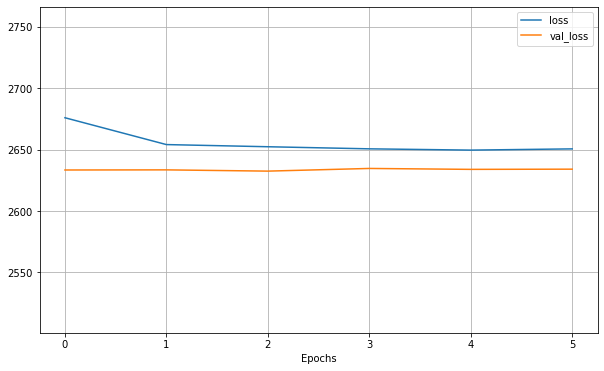

CLONING DEMOGRAPHIC MODEL
Epoch 1/50
1215/1215 [==============================] - 5s 3ms/step - loss: 3010.2883 - val_loss: 2941.6641
Epoch 2/50
1215/1215 [==============================] - 4s 3ms/step - loss: 2947.9180 - val_loss: 2938.9246
Epoch 3/50
1215/1215 [==============================] - 4s 3ms/step - loss: 2947.8533 - val_loss: 2938.4648
Epoch 4/50
1215/1215 [==============================] - 4s 3ms/step - loss: 2947.8613 - val_loss: 2938.7312
Epoch 5/50
1215/1215 [==============================] - 4s 3ms/step - loss: 2947.0161 - val_loss: 2937.8899
Epoch 6/50
1215/1215 [==============================] - 4s 3ms/step - loss: 2946.8958 - val_loss: 2938.9514
Epoch 7/50
1215/1215 [==============================] - 4s 3ms/step - loss: 2946.5369 - val_loss: 2938.7256
Epoch 8/50
1215/1215 [==============================] - 1s 1ms/step - loss: 2942.0967
MAE 2942.0966796875


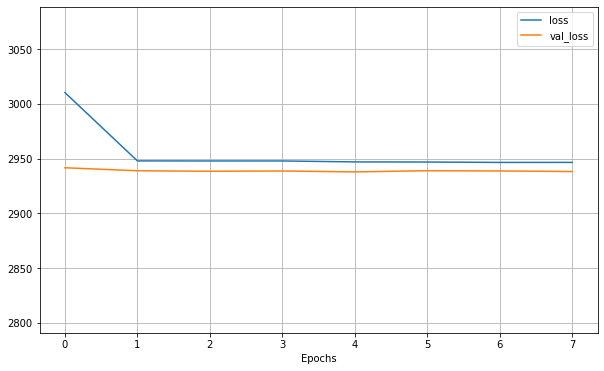

COMBINING BOTH MODELS FOR FINAL MODEL
Epoch 1/50
2429/2429 [==============================] - 45s 18ms/step - loss: 4485.4634 - val_loss: 3195.9998
Epoch 2/50
2429/2429 [==============================] - 42s 17ms/step - loss: 3063.6360 - val_loss: 2819.9375
Epoch 3/50
2429/2429 [==============================] - 42s 17ms/step - loss: 2758.5027 - val_loss: 2654.1877
Epoch 4/50
2429/2429 [==============================] - 43s 18ms/step - loss: 2706.7031 - val_loss: 2645.9944
Epoch 5/50
2429/2429 [==============================] - 43s 18ms/step - loss: 2698.9976 - val_loss: 2638.3650
Epoch 6/50
2429/2429 [==============================] - 42s 17ms/step - loss: 2690.9912 - val_loss: 2636.4690
Epoch 7/50
2429/2429 [==============================] - 43s 18ms/step - loss: 2669.3376 - val_loss: 2635.7007
Epoch 8/50
2429/2429 [==============================] - 43s 18ms/step - loss: 2660.0020 - val_loss: 2632.8735
Epoch 9/50
2429/2429 [==============================] - 41s 17ms/step - loss: 2659

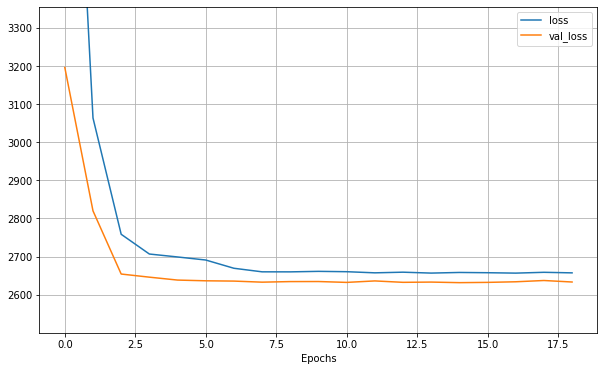

In [26]:
"""
Sub group codes:
65==COPD
101==HF/Shock
152==Maj. joint replacement
294==Septicemia

targets==["TotalDirectCost", "DeathFlag", "LOS"]
"""

X_train, X_valid, X_test, y_train, y_valid, y_test, ds = prep_data(group=101, target='TotalDirectCost', 
                                                      data=data, ids=ids, raw_tdf=raw_tdf)



X_age_train = X_train[:, -1:]
X_age_valid = X_valid[:, -1:]
X_age_test = X_test[:, -1:]

X_train = X_train[:, :-1]
X_valid = X_valid[:, :-1]
X_test = X_test[:, :-1]

diag_X_train = X_train[:, :ds[1]]
diag_X_valid = X_valid[:, :ds[1]]
diag_X_test = X_test[:, :ds[1]]

demo_X_train = X_train[:, ds[1]:-1]
demo_X_valid = X_valid[:, ds[1]:-1]
demo_X_test = X_test[:, ds[1]:-1]

print(X_train.shape)
print(X_valid.shape)


print('CLONING DIAGNOSIS MODEL')
shock_diag = clone_train_diagnosis_model(lr=0.003, batchsize=128, target="TotalDirectCost", 
                                        num_frozen_layers=1, base_model=diag_model, patience=3,
                                        diag_X_train=diag_X_train, diag_X_valid=diag_X_valid, diag_X_test=diag_X_test,
                                        y_train=y_train, y_valid=y_valid, y_test=y_test)
print('CLONING DEMOGRAPHIC MODEL')
shock_demo = clone_train_demographic_model(lr=0.001, batchsize=128, 
                                          num_frozen_layers=0, base_model=demo_model, patience=3,
                                          demo_X_train=demo_X_train, demo_X_valid=demo_X_valid, demo_X_test=demo_X_test,
                                          y_train=y_train, y_valid=y_valid, y_test=y_test)
print('COMBINING BOTH MODELS FOR FINAL MODEL')
shock_cost_model = mate_both_models_together(lr=0.0002, batchsize=128,  patience=4,
                                            cloned_diag_model=shock_diag, 
                                            cloned_demo_model=shock_demo,
                                            diag_X_train=diag_X_train, diag_X_valid=diag_X_valid, 
                                            diag_X_test=diag_X_test, demo_X_train=demo_X_train, 
                                            demo_X_valid=demo_X_valid, demo_X_test=demo_X_test,
                                            y_train=y_train, y_valid=y_valid, y_test=y_test)


#OG was: 2835; RF=2903, linear=2764

(310800, 544)
(38850, 544)
CLONING DIAGNOSIS MODEL
Epoch 1/50
2429/2429 [==============================] - 62s 25ms/step - loss: 455.1583 - val_loss: 3.2991
Epoch 2/50
2429/2429 [==============================] - 63s 26ms/step - loss: 3.9930 - val_loss: 2.7051
Epoch 3/50
2429/2429 [==============================] - 61s 25ms/step - loss: 3.0549 - val_loss: 2.6315
Epoch 4/50
2429/2429 [==============================] - 62s 25ms/step - loss: 2.7712 - val_loss: 2.5801
Epoch 5/50
2429/2429 [==============================] - 61s 25ms/step - loss: 2.6704 - val_loss: 2.5662
Epoch 6/50
2429/2429 [==============================] - 62s 25ms/step - loss: 2.6249 - val_loss: 2.6360
Epoch 7/50
2429/2429 [==============================] - 63s 26ms/step - loss: 2.5955 - val_loss: 2.5287
Epoch 8/50
2429/2429 [==============================] - 61s 25ms/step - loss: 2.5787 - val_loss: 2.5120
Epoch 9/50
2429/2429 [==============================] - 62s 26ms/step - loss: 2.5642 - val_loss: 2.5170
Epoch 10/50

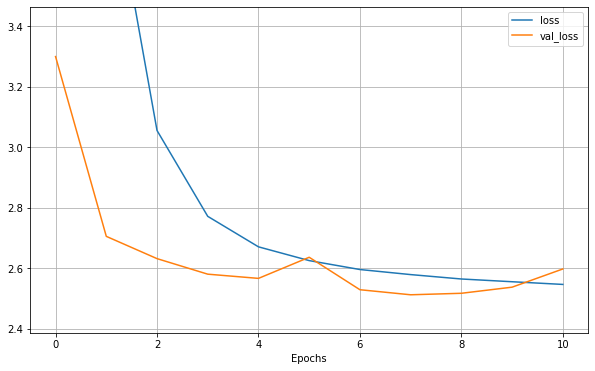

CLONING DEMOGRAPHIC MODEL
Epoch 1/50
1215/1215 [==============================] - 5s 4ms/step - loss: 4238.7012 - val_loss: 2796.7268
Epoch 2/50
1215/1215 [==============================] - 4s 3ms/step - loss: 1780.3949 - val_loss: 1000.6201
Epoch 3/50
1215/1215 [==============================] - 4s 3ms/step - loss: 550.9692 - val_loss: 224.3414
Epoch 4/50
1215/1215 [==============================] - 4s 3ms/step - loss: 81.7148 - val_loss: 3.7189
Epoch 5/50
1215/1215 [==============================] - 4s 3ms/step - loss: 2.8445 - val_loss: 2.9089
Epoch 6/50
1215/1215 [==============================] - 4s 3ms/step - loss: 2.7940 - val_loss: 2.8242
Epoch 7/50
1215/1215 [==============================] - 4s 3ms/step - loss: 2.7881 - val_loss: 2.8284
Epoch 8/50
1215/1215 [==============================] - 4s 3ms/step - loss: 2.7894 - val_loss: 2.8102
Epoch 9/50
1215/1215 [==============================] - 4s 3ms/step - loss: 2.7828 - val_loss: 2.6745
Epoch 10/50
1215/1215 [================

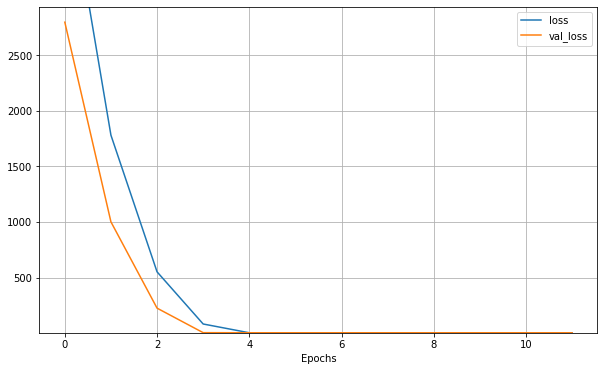

COMBINING BOTH MODELS FOR FINAL MODEL
Epoch 1/50
2429/2429 [==============================] - 45s 18ms/step - loss: 2.9771 - val_loss: 2.6034
Epoch 2/50
2429/2429 [==============================] - 40s 17ms/step - loss: 2.6222 - val_loss: 2.5692
Epoch 3/50
2429/2429 [==============================] - 42s 17ms/step - loss: 2.6002 - val_loss: 2.5673
Epoch 4/50
2429/2429 [==============================] - 42s 17ms/step - loss: 2.5909 - val_loss: 2.5569
Epoch 5/50
2429/2429 [==============================] - 40s 17ms/step - loss: 2.5822 - val_loss: 2.5298
Epoch 6/50
2429/2429 [==============================] - 41s 17ms/step - loss: 2.5803 - val_loss: 2.5297
Epoch 7/50
2429/2429 [==============================] - 40s 16ms/step - loss: 2.5799 - val_loss: 2.5389
Epoch 8/50
2429/2429 [==============================] - 41s 17ms/step - loss: 2.5727 - val_loss: 2.5500
Epoch 9/50
2429/2429 [==============================] - 41s 17ms/step - loss: 2.5665 - val_loss: 2.5391
Epoch 10/50
2429/2429 [===

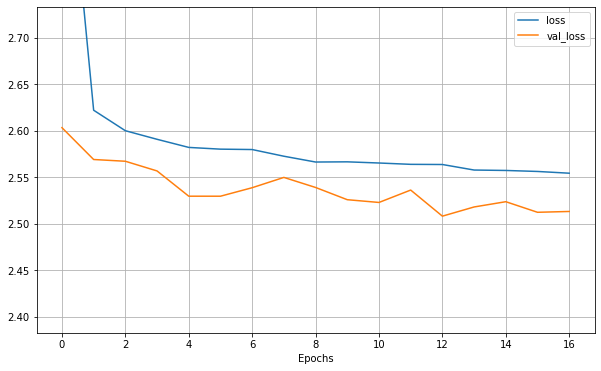

In [27]:
"""
Sub group codes:
65==COPD
101==HF/Shock
152==Maj. joint replacement
294==Septicemia

targets==["TotalDirectCost", "DeathFlag", "LOS"]
"""

X_train, X_valid, X_test, y_train, y_valid, y_test, ds = prep_data(group=101, target='LOS', 
                                                      data=data, ids=ids, raw_tdf=raw_tdf)



X_age_train = X_train[:, -1:]
X_age_valid = X_valid[:, -1:]
X_age_test = X_test[:, -1:]

X_train = X_train[:, :-1]
X_valid = X_valid[:, :-1]
X_test = X_test[:, :-1]

diag_X_train = X_train[:, :ds[1]]
diag_X_valid = X_valid[:, :ds[1]]
diag_X_test = X_test[:, :ds[1]]

demo_X_train = X_train[:, ds[1]:-1]
demo_X_valid = X_valid[:, ds[1]:-1]
demo_X_test = X_test[:, ds[1]:-1]

print(X_train.shape)
print(X_valid.shape)


print('CLONING DIAGNOSIS MODEL')
shock_diag = clone_train_diagnosis_model(lr=0.003, batchsize=128, target="LOS", 
                                        num_frozen_layers=1, base_model=diag_model, patience=3,
                                        diag_X_train=diag_X_train, diag_X_valid=diag_X_valid, diag_X_test=diag_X_test,
                                        y_train=y_train, y_valid=y_valid, y_test=y_test)
print('CLONING DEMOGRAPHIC MODEL')
shock_demo = clone_train_demographic_model(lr=0.001, batchsize=128, 
                                          num_frozen_layers=0, base_model=demo_model, patience=3,
                                          demo_X_train=demo_X_train, demo_X_valid=demo_X_valid, demo_X_test=demo_X_test,
                                          y_train=y_train, y_valid=y_valid, y_test=y_test)
print('COMBINING BOTH MODELS FOR FINAL MODEL')
shock_los_model = mate_both_models_together(lr=0.0002, batchsize=128,  patience=4,
                                            cloned_diag_model=shock_diag, 
                                            cloned_demo_model=shock_demo,
                                            diag_X_train=diag_X_train, diag_X_valid=diag_X_valid, 
                                            diag_X_test=diag_X_test, demo_X_train=demo_X_train, 
                                            demo_X_valid=demo_X_valid, demo_X_test=demo_X_test,
                                            y_train=y_train, y_valid=y_valid, y_test=y_test)


#OG was: 2.53; RF=2.61, linear=2.53

# THK/Major Joint Replacement

(267612, 544)
(33452, 544)
CLONING DIAGNOSIS MODEL
Epoch 1/50
2091/2091 [==============================] - 54s 25ms/step - loss: 2778.4773 - val_loss: 2684.5029
Epoch 2/50
2091/2091 [==============================] - 52s 25ms/step - loss: 2710.7837 - val_loss: 2682.4536
Epoch 3/50
2091/2091 [==============================] - 52s 25ms/step - loss: 2708.8816 - val_loss: 2682.6223
Epoch 4/50
2091/2091 [==============================] - 52s 25ms/step - loss: 2705.9189 - val_loss: 2683.6096
Epoch 5/50
1046/1046 [==============================] - 3s 3ms/step - loss: 2710.5217
MAE 2710.521728515625


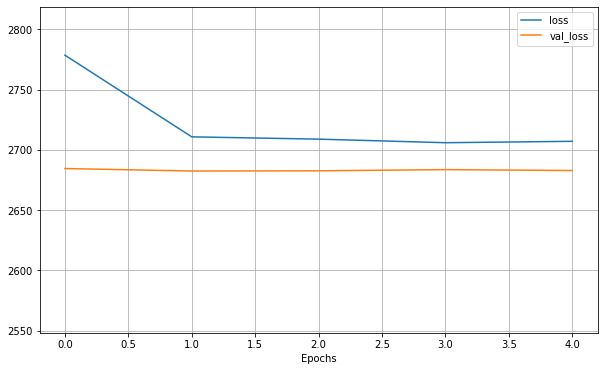

CLONING DEMOGRAPHIC MODEL
Epoch 1/50
2091/2091 [==============================] - 8s 3ms/step - loss: 2958.9736 - val_loss: 2723.0364
Epoch 2/50
2091/2091 [==============================] - 7s 3ms/step - loss: 2731.2144 - val_loss: 2723.0188
Epoch 3/50
2091/2091 [==============================] - 7s 3ms/step - loss: 2730.9331 - val_loss: 2725.5479
Epoch 4/50
2091/2091 [==============================] - 7s 3ms/step - loss: 2730.0518 - val_loss: 2722.5732
Epoch 5/50
2091/2091 [==============================] - 7s 3ms/step - loss: 2729.1157 - val_loss: 2723.5527
Epoch 6/50
2091/2091 [==============================] - 7s 3ms/step - loss: 2729.4490 - val_loss: 2723.1611
Epoch 7/50
2091/2091 [==============================] - 7s 3ms/step - loss: 2729.2903 - val_loss: 2720.6282
Epoch 8/50
2091/2091 [==============================] - 7s 3ms/step - loss: 2727.9878 - val_loss: 2719.9038
Epoch 9/50
2091/2091 [==============================] - 7s 3ms/step - loss: 2729.2563 - val_loss: 2720.9734
Ep

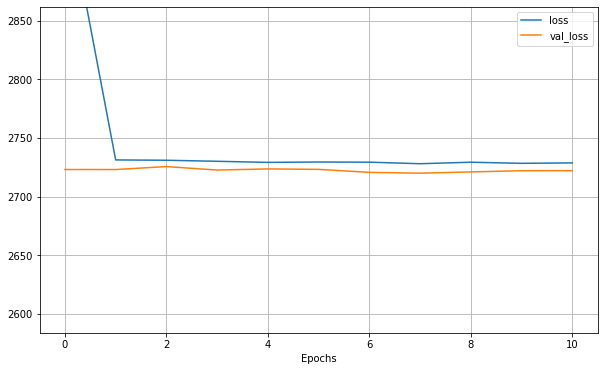

COMBINING BOTH MODELS FOR FINAL MODEL
Epoch 1/50
2091/2091 [==============================] - 40s 18ms/step - loss: 8752.3359 - val_loss: 6467.2026
Epoch 2/50
2091/2091 [==============================] - 37s 18ms/step - loss: 5204.3149 - val_loss: 3520.4285
Epoch 3/50
2091/2091 [==============================] - 37s 18ms/step - loss: 3660.5022 - val_loss: 3135.5637
Epoch 4/50
2091/2091 [==============================] - 37s 18ms/step - loss: 3255.6475 - val_loss: 2903.5559
Epoch 5/50
2091/2091 [==============================] - 37s 18ms/step - loss: 2946.7935 - val_loss: 2808.6255
Epoch 6/50
2091/2091 [==============================] - 37s 18ms/step - loss: 2887.7180 - val_loss: 2784.0005
Epoch 7/50
2091/2091 [==============================] - 37s 18ms/step - loss: 2845.5269 - val_loss: 2727.2380
Epoch 8/50
2091/2091 [==============================] - 37s 18ms/step - loss: 2733.7471 - val_loss: 2695.3057
Epoch 9/50
2091/2091 [==============================] - 38s 18ms/step - loss: 2725

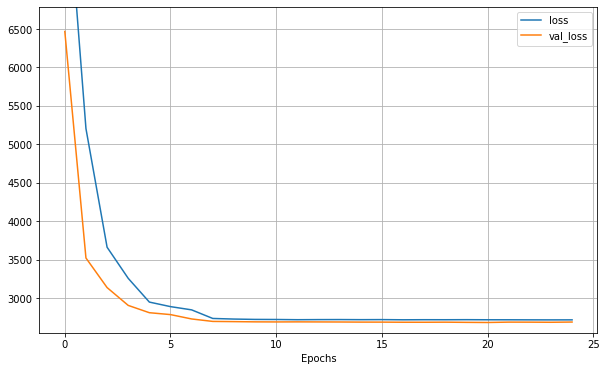

In [109]:
"""
Sub group codes:
65==COPD
101==HF/Shock
152==Maj. joint replacement
294==Septicemia

targets==["TotalDirectCost", "DeathFlag", "LOS"]
"""

X_train, X_valid, X_test, y_train, y_valid, y_test, ds = prep_data(group=152, target='TotalDirectCost', 
                                                      data=data, ids=ids, raw_tdf=raw_tdf)



X_age_train = X_train[:, -1:]
X_age_valid = X_valid[:, -1:]
X_age_test = X_test[:, -1:]

X_train = X_train[:, :-1]
X_valid = X_valid[:, :-1]
X_test = X_test[:, :-1]

diag_X_train = X_train[:, :ds[1]]
diag_X_valid = X_valid[:, :ds[1]]
diag_X_test = X_test[:, :ds[1]]

demo_X_train = X_train[:, ds[1]:-1]
demo_X_valid = X_valid[:, ds[1]:-1]
demo_X_test = X_test[:, ds[1]:-1]

print(X_train.shape)
print(X_valid.shape)


print('CLONING DIAGNOSIS MODEL')
joint_diag = clone_train_diagnosis_model(lr=0.003, batchsize=128, target="TotalDirectCost", 
                                        num_frozen_layers=1, base_model=diag_model, patience=3,
                                        diag_X_train=diag_X_train, diag_X_valid=diag_X_valid, diag_X_test=diag_X_test,
                                        y_train=y_train, y_valid=y_valid, y_test=y_test)
print('CLONING DEMOGRAPHIC MODEL')
joint_demo = clone_train_demographic_model(lr=0.001, batchsize=128, 
                                          num_frozen_layers=0, base_model=demo_model, patience=3,
                                          demo_X_train=demo_X_train, demo_X_valid=demo_X_valid, demo_X_test=demo_X_test,
                                          y_train=y_train, y_valid=y_valid, y_test=y_test)
print('COMBINING BOTH MODELS FOR FINAL MODEL')
joint_cost_model = mate_both_models_together(lr=0.0002, batchsize=128,  patience=4,
                                            cloned_diag_model=joint_diag, 
                                            cloned_demo_model=joint_demo,
                                            diag_X_train=diag_X_train, diag_X_valid=diag_X_valid, 
                                            diag_X_test=diag_X_test, demo_X_train=demo_X_train, 
                                            demo_X_valid=demo_X_valid, demo_X_test=demo_X_test,
                                            y_train=y_train, y_valid=y_valid, y_test=y_test)


#OG was: 2839; RF=2777, linear=2775

(267612, 544)
(33452, 544)
CLONING DIAGNOSIS MODEL
Epoch 1/50
2091/2091 [==============================] - 54s 25ms/step - loss: 527.2396 - val_loss: 12.0835
Epoch 2/50
2091/2091 [==============================] - 52s 25ms/step - loss: 4.2042 - val_loss: 1.2288
Epoch 3/50
2091/2091 [==============================] - 53s 25ms/step - loss: 1.9104 - val_loss: 1.2368
Epoch 4/50
2091/2091 [==============================] - 53s 25ms/step - loss: 1.3908 - val_loss: 1.1970
Epoch 5/50
2091/2091 [==============================] - 52s 25ms/step - loss: 1.2281 - val_loss: 1.1765
Epoch 6/50
2091/2091 [==============================] - 53s 25ms/step - loss: 1.1714 - val_loss: 1.1216
Epoch 7/50
2091/2091 [==============================] - 53s 25ms/step - loss: 1.1456 - val_loss: 1.1610
Epoch 8/50
2091/2091 [==============================] - 53s 25ms/step - loss: 1.1256 - val_loss: 1.1185
Epoch 9/50
2091/2091 [==============================] - 52s 25ms/step - loss: 1.1091 - val_loss: 1.0889
Epoch 10/5

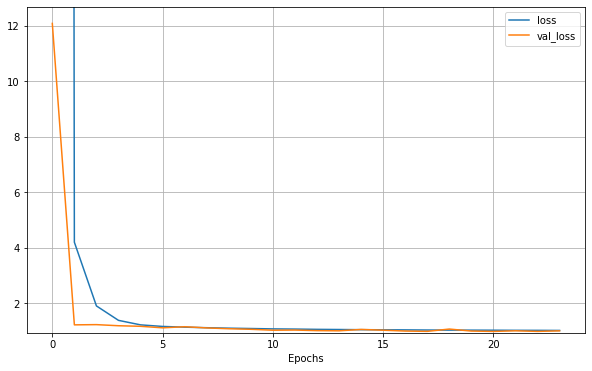

CLONING DEMOGRAPHIC MODEL
Epoch 1/50
2091/2091 [==============================] - 8s 3ms/step - loss: 3308.1895 - val_loss: 1328.0793
Epoch 2/50
2091/2091 [==============================] - 7s 3ms/step - loss: 552.2263 - val_loss: 65.9761
Epoch 3/50
2091/2091 [==============================] - 7s 3ms/step - loss: 11.0706 - val_loss: 1.2111
Epoch 4/50
2091/2091 [==============================] - 7s 3ms/step - loss: 1.0834 - val_loss: 0.9625
Epoch 5/50
2091/2091 [==============================] - 7s 3ms/step - loss: 1.1234 - val_loss: 0.9883
Epoch 6/50
2091/2091 [==============================] - 7s 3ms/step - loss: 1.1076 - val_loss: 1.3915
Epoch 7/50
1046/1046 [==============================] - 1s 991us/step - loss: 0.9579
MAE 0.9579307436943054


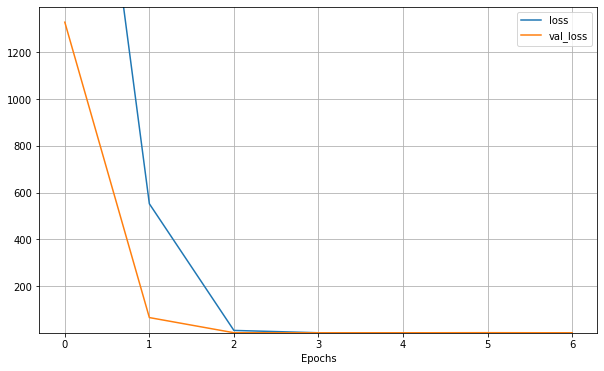

COMBINING BOTH MODELS FOR FINAL MODEL
Epoch 1/50
2091/2091 [==============================] - 37s 17ms/step - loss: 1.4418 - val_loss: 1.1640
Epoch 2/50
2091/2091 [==============================] - 34s 16ms/step - loss: 1.0804 - val_loss: 1.0762
Epoch 3/50
2091/2091 [==============================] - 35s 17ms/step - loss: 1.0589 - val_loss: 1.0526
Epoch 4/50
2091/2091 [==============================] - 36s 17ms/step - loss: 1.0480 - val_loss: 1.0122
Epoch 5/50
2091/2091 [==============================] - 36s 17ms/step - loss: 1.0432 - val_loss: 1.0084
Epoch 6/50
2091/2091 [==============================] - 34s 16ms/step - loss: 1.0395 - val_loss: 1.0239
Epoch 7/50
2091/2091 [==============================] - 35s 17ms/step - loss: 1.0345 - val_loss: 1.0142
Epoch 8/50
2091/2091 [==============================] - 36s 17ms/step - loss: 1.0310 - val_loss: 1.0063
Epoch 9/50
2091/2091 [==============================] - 35s 17ms/step - loss: 1.0313 - val_loss: 0.9969
Epoch 10/50
2091/2091 [===

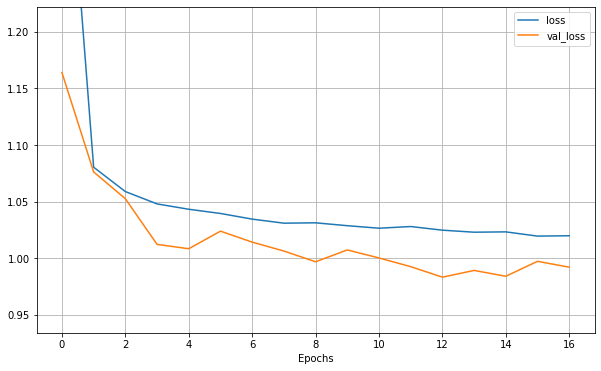

In [110]:
"""
Sub group codes:
65==COPD
101==HF/Shock
152==Maj. joint replacement
294==Septicemia

targets==["TotalDirectCost", "DeathFlag", "LOS"]
"""

X_train, X_valid, X_test, y_train, y_valid, y_test, ds = prep_data(group=152, target='LOS', 
                                                      data=data, ids=ids, raw_tdf=raw_tdf)



X_age_train = X_train[:, -1:]
X_age_valid = X_valid[:, -1:]
X_age_test = X_test[:, -1:]

X_train = X_train[:, :-1]
X_valid = X_valid[:, :-1]
X_test = X_test[:, :-1]

diag_X_train = X_train[:, :ds[1]]
diag_X_valid = X_valid[:, :ds[1]]
diag_X_test = X_test[:, :ds[1]]

demo_X_train = X_train[:, ds[1]:-1]
demo_X_valid = X_valid[:, ds[1]:-1]
demo_X_test = X_test[:, ds[1]:-1]

print(X_train.shape)
print(X_valid.shape)


print('CLONING DIAGNOSIS MODEL')
joint_diag = clone_train_diagnosis_model(lr=0.003, batchsize=128, target="LOS", 
                                        num_frozen_layers=1, base_model=diag_model, patience=3,
                                        diag_X_train=diag_X_train, diag_X_valid=diag_X_valid, diag_X_test=diag_X_test,
                                        y_train=y_train, y_valid=y_valid, y_test=y_test)
print('CLONING DEMOGRAPHIC MODEL')
joint_demo = clone_train_demographic_model(lr=0.001, batchsize=128, 
                                          num_frozen_layers=0, base_model=demo_model, patience=3,
                                          demo_X_train=demo_X_train, demo_X_valid=demo_X_valid, demo_X_test=demo_X_test,
                                          y_train=y_train, y_valid=y_valid, y_test=y_test)
print('COMBINING BOTH MODELS FOR FINAL MODEL')
joint_los_model = mate_both_models_together(lr=0.0002, batchsize=128,  patience=4,
                                            cloned_diag_model=joint_diag, 
                                            cloned_demo_model=joint_demo,
                                            diag_X_train=diag_X_train, diag_X_valid=diag_X_valid, 
                                            diag_X_test=diag_X_test, demo_X_train=demo_X_train, 
                                            demo_X_valid=demo_X_valid, demo_X_test=demo_X_test,
                                            y_train=y_train, y_valid=y_valid, y_test=y_test)


#OG was: 0.92; RF=0.98, linear=0.98